Aim of this notebook is to look at calibrated stereo images and to visualize some mathematical properties of pairs of matched keypoints, found by opencv sift algorithms or our pysift implementation.


Imports


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# add the path to the visualize_hessian folder
sys.path.append(os.path.join("..", "visualize_hessian"))

import visu_hessian as vh

# return to the root directory
sys.path.append(os.path.join(".."))

# add the path to the visualize_hessian folder
sys.path.append(os.path.join("..", "descriptor"))

import descriptor.descriptor as desc

# return to the root directory
sys.path.append(os.path.join(".."))

# Load grayscale image


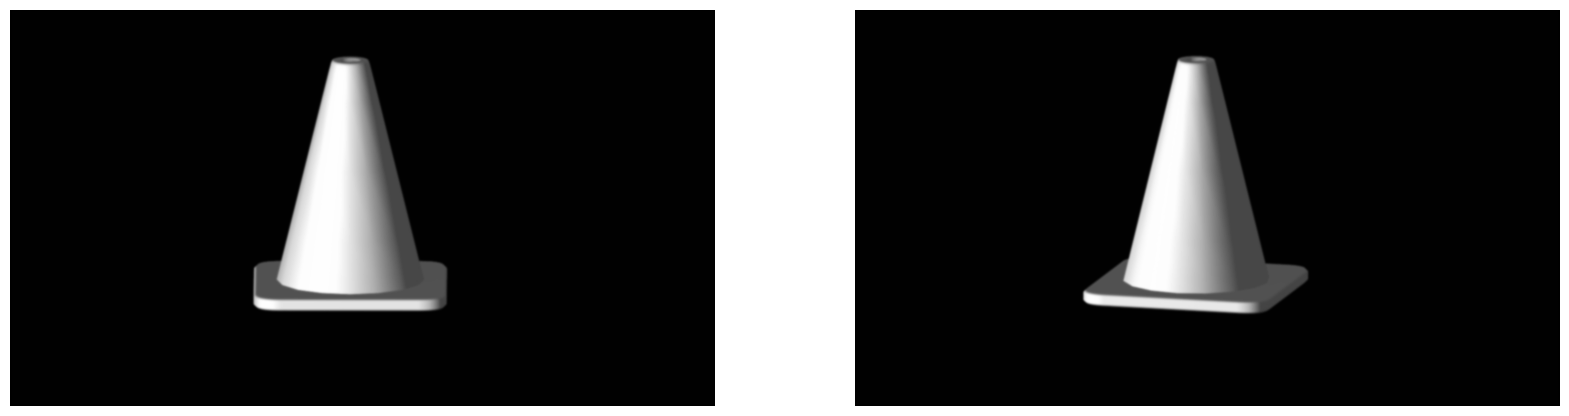

Image 1 min: 0.07323255686698223
Image 1 max: 0.9494560939991873
Image 1 mean: 0.232126457285815
Image 1 std: 0.17135680773746415
Image 1 shape: (702, 1248)
Image 1 dtype: float64
Image 1 size: 876096

Image 2 min: 0.07323255686698224
Image 2 max: 0.9491644655528676
Image 2 mean: 0.22768039646215568
Image 2 std: 0.1604422980691601
Image 2 shape: (702, 1248)
Image 2 dtype: float64
Image 2 size: 876096



In [17]:
img_folder = "../data/blender"
im_name1 = "cone1"
im_name2 = "cone2"
im_names = [im_name1, im_name2]
im_ext = "jpg"
im1 = cv.imread(f"{img_folder}/{im_name1}.{im_ext}", cv.IMREAD_GRAYSCALE)
im2 = cv.imread(f"{img_folder}/{im_name2}.{im_ext}", cv.IMREAD_GRAYSCALE)
ims = [im1, im2]

# compute float32 versions for calculations
float_im1 = vh.convert_uint8_to_float32(im1)
float_im2 = vh.convert_uint8_to_float32(im2)

# blur images
float_ims = [float_im1, float_im2]
blur_sigma = 1.6
float_ims = [desc.convolve_2D_gaussian(float_ims[i], blur_sigma) for i in range(2)]

# compute min and max values for normalization
min_val = min(float_im1.min(), float_im2.min())
max_val = max(float_im1.max(), float_im2.max())
min_vals, max_vals = [min_val, min_val], [max_val, max_val]

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(float_ims[0], cmap="gray", vmin=min_val, vmax=max_val)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(float_ims[1], cmap="gray", vmin=min_val, vmax=max_val)
plt.axis("off")
plt.show()

# print extrema values
for i, im in enumerate(float_ims):
    print(f"Image {i+1} min: {im.min()}")
    print(f"Image {i+1} max: {im.max()}")
    print(f"Image {i+1} mean: {im.mean()}")
    print(f"Image {i+1} std: {im.std()}")
    print(f"Image {i+1} shape: {im.shape}")
    print(f"Image {i+1} dtype: {im.dtype}")
    print(f"Image {i+1} size: {im.size}")
    print("")

# Match SIFT Keypoints on stereo setup


In [3]:
# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

# print number of keypoints detected in each image
print(f"Number of keypoints detected in {im_name1}: {len(kp1)}")
print(f"Number of keypoints detected in {im_name2}: {len(kp2)}")

Number of keypoints detected in cone1: 23
Number of keypoints detected in cone2: 21


In [4]:
# BFMatcher with default params
# default norm is L2
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
threshold = 0.75
good = []
for m, n in matches:
    if m.distance < threshold * n.distance:
        good.append([m])

# Alternative: crossCheck=True
bf_CC = cv.BFMatcher(crossCheck=True)
matches_CC = bf_CC.match(des1, des2)

# Sort them in the order of their distance.
good_sorted = sorted(good, key=lambda x: x[0].distance)
matches_CC_sorted = sorted(matches_CC, key=lambda x: x.distance)

# print the distances
print("Distances with Lowe's ratio:")
for m in good_sorted[:10]:
    print(f"{m[0].distance:.2f}", end=" ")

print("\nDistances with crossCheck:")
for m in matches_CC_sorted[:10]:
    print(f"{m.distance:.2f}", end=" ")

Distances with Lowe's ratio:
30.45 34.34 42.44 43.06 67.85 181.81 
Distances with crossCheck:
30.45 34.34 42.44 43.06 67.85 92.84 174.55 181.81 277.09 277.46 

In [5]:
# %%script false
# cv.drawMatchesKnn expects list of lists as matches.
nb_matches_to_draw = 100

img3 = cv.drawMatchesKnn(
    im1,
    kp1,
    im2,
    kp2,
    good_sorted[:nb_matches_to_draw],
    outImg=None,
    singlePointColor=(255, 0, 0),
)
img4 = cv.drawMatches(
    im1,
    kp1,
    im2,
    kp2,
    matches_CC_sorted[:nb_matches_to_draw],
    singlePointColor=(255, 0, 0),
    outImg=None,
)

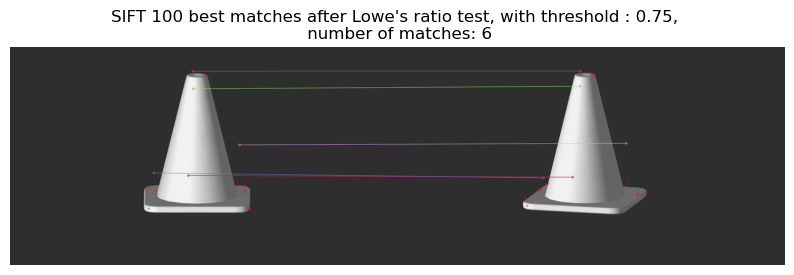

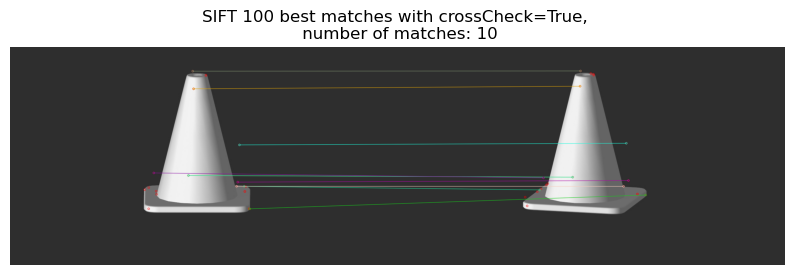

In [6]:
# %%script false
# display matches
plt.figure(figsize=(10, 5))
plt.imshow(img3)
plt.axis("off")
plt.title(
    f"SIFT {nb_matches_to_draw} best matches after Lowe's ratio test, with threshold : {threshold}, \n number of matches: {len(good)}"
)
# save figure
# plt.savefig(
#     f"{img_folder}/{im_name1}_sift_matches_{nb_matches_to_draw}_lowe.png", dpi=600
# )
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(img4)
plt.axis("off")
plt.title(
    f"SIFT {nb_matches_to_draw} best matches with crossCheck=True, \n number of matches: {len(matches_CC)}"
)
# save figure
# plt.savefig(
#     f"{img_folder}/{im_name1}_sift_matches_{nb_matches_to_draw}_crossCheck.png", dpi=600
# )
plt.show()

# Visualize gradients and curvatures


In [7]:
# store keypoints of good matches in 2 lists, 1 per image
kp_img1 = []
kp_img2 = []

for m in good_sorted:
    kp_img1.append(kp1[m[0].queryIdx])
    kp_img2.append(kp2[m[0].trainIdx])

# print lengths of lists
print(f"Number of 'good' matched keypoints in {im_name1}: {len(kp_img1)}")
print(f"Number of 'good' matched keypoints in {im_name2}: {len(kp_img2)}")

Number of 'good' matched keypoints in cone1: 6
Number of 'good' matched keypoints in cone2: 6


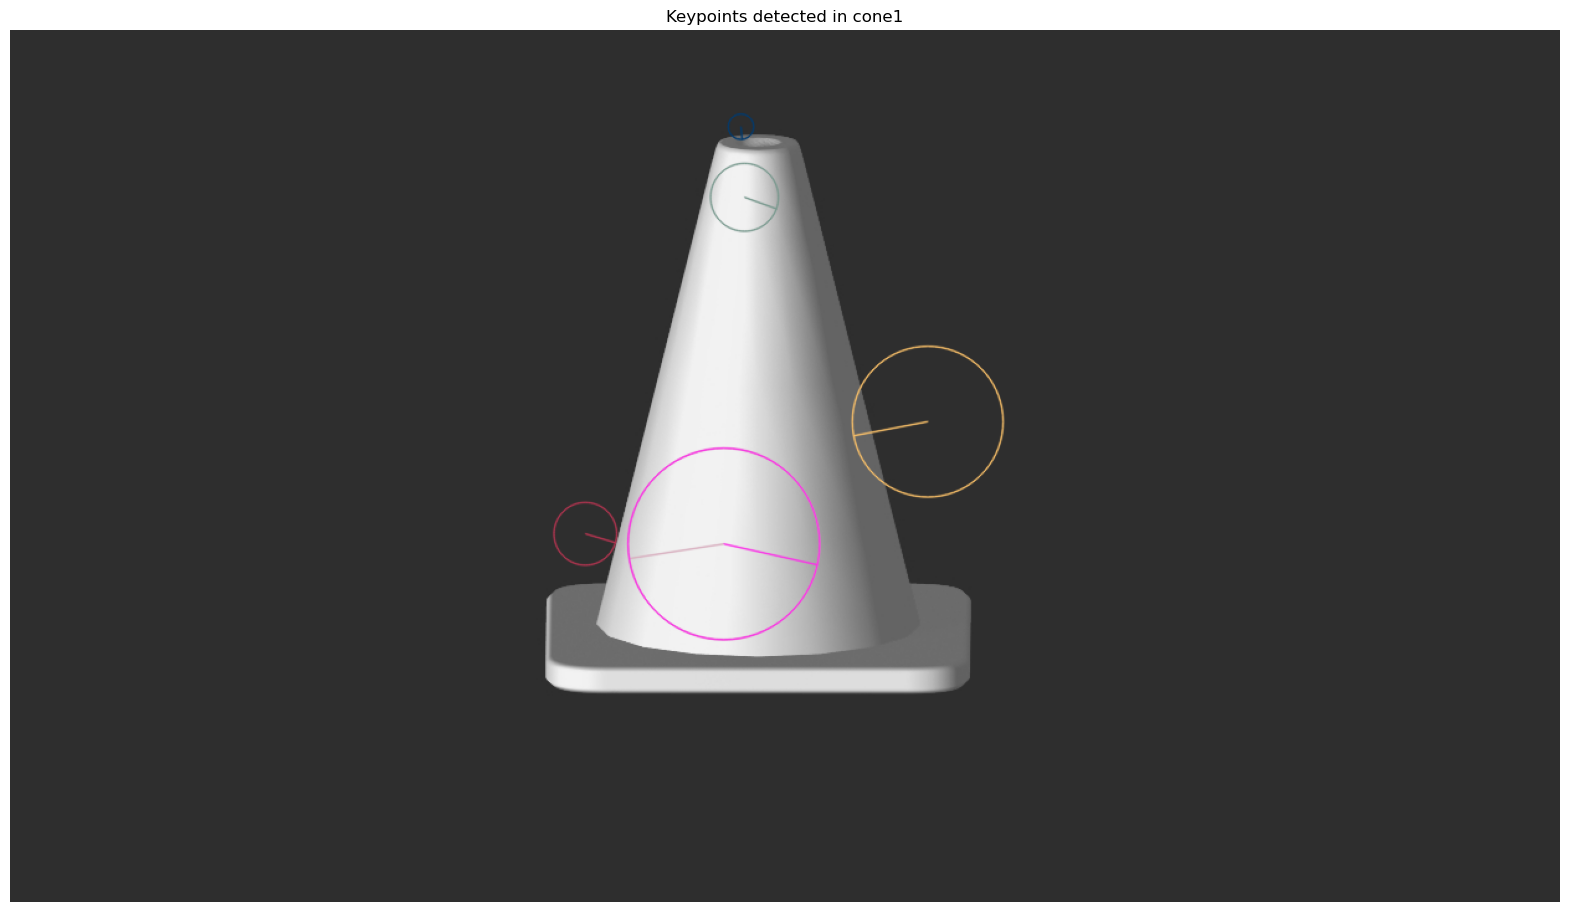

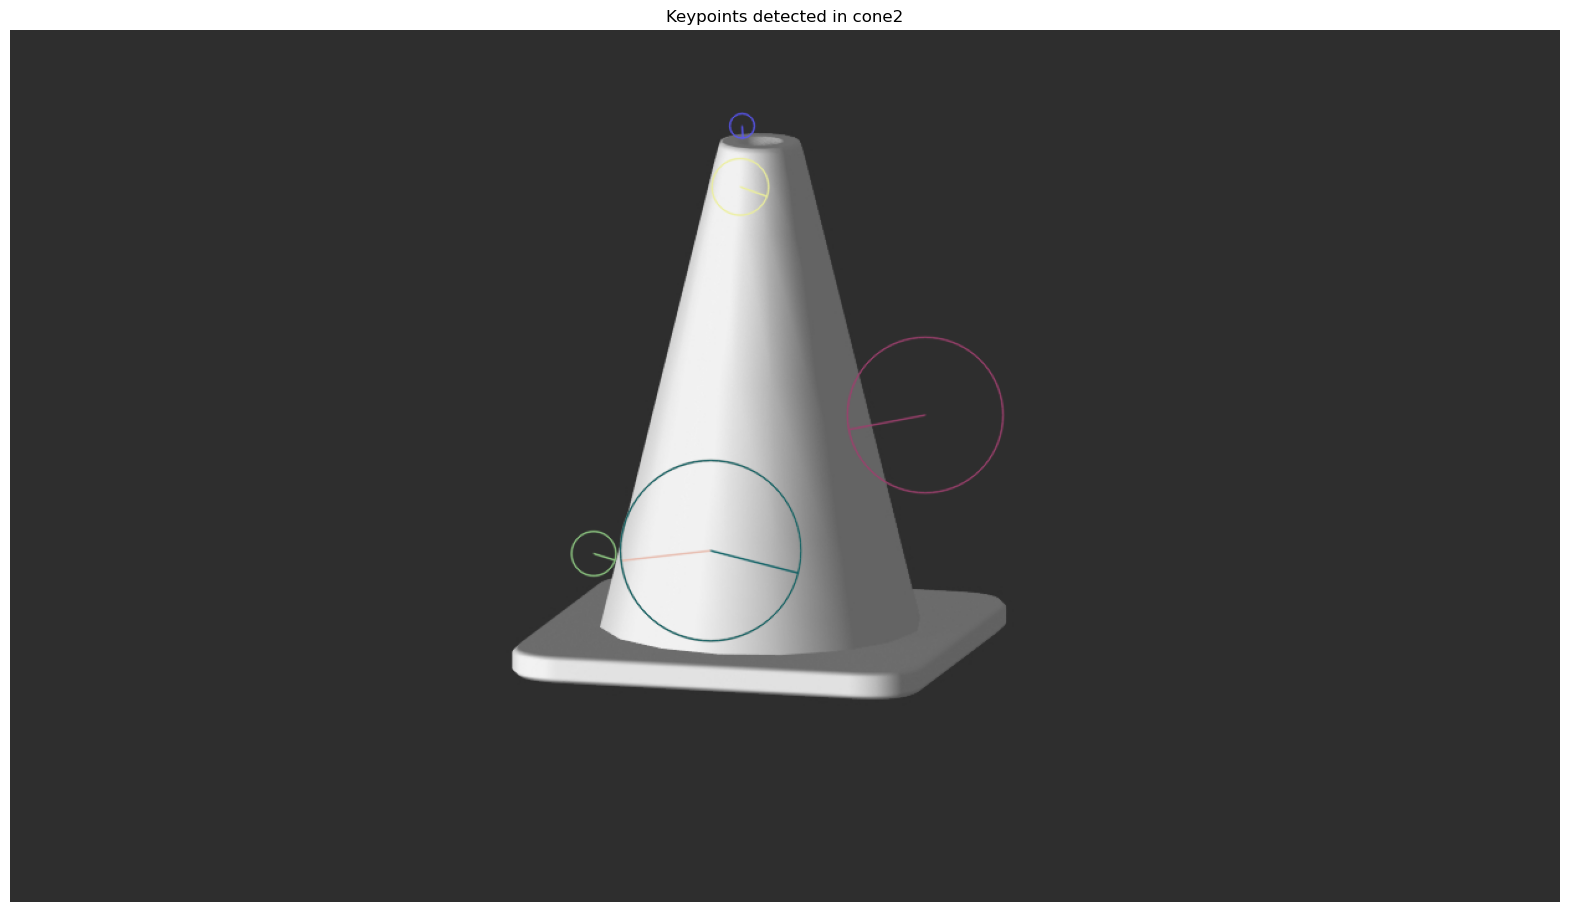

In [8]:
# %%script false
# show image 1 with keypoints
kp_img1_draw = cv.drawKeypoints(
    im1, kp_img1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.figure(figsize=(20, 20))
plt.imshow(kp_img1_draw)
plt.axis("off")
plt.title(f"Keypoints detected in {im_name1}")
# save figure
# plt.savefig(f"{img_folder}/cubes_sift_kp1.png", dpi=600)
plt.show()

# show image 2 with keypoints
kp_img2_draw = cv.drawKeypoints(
    im2, kp_img2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.figure(figsize=(20, 20))
plt.imshow(kp_img2_draw)
plt.axis("off")
plt.title(f"Keypoints detected in {im_name2}")
# save figure
# plt.savefig(f"{img_folder}/cubes_sift_kp2.png", dpi=600)
plt.show()

Show curvature values


In [9]:
zoom_radius = 50
kp_index = 4
kp1 = kp_img1[kp_index]
kp2 = kp_img2[kp_index]
kps = [kp1, kp2]

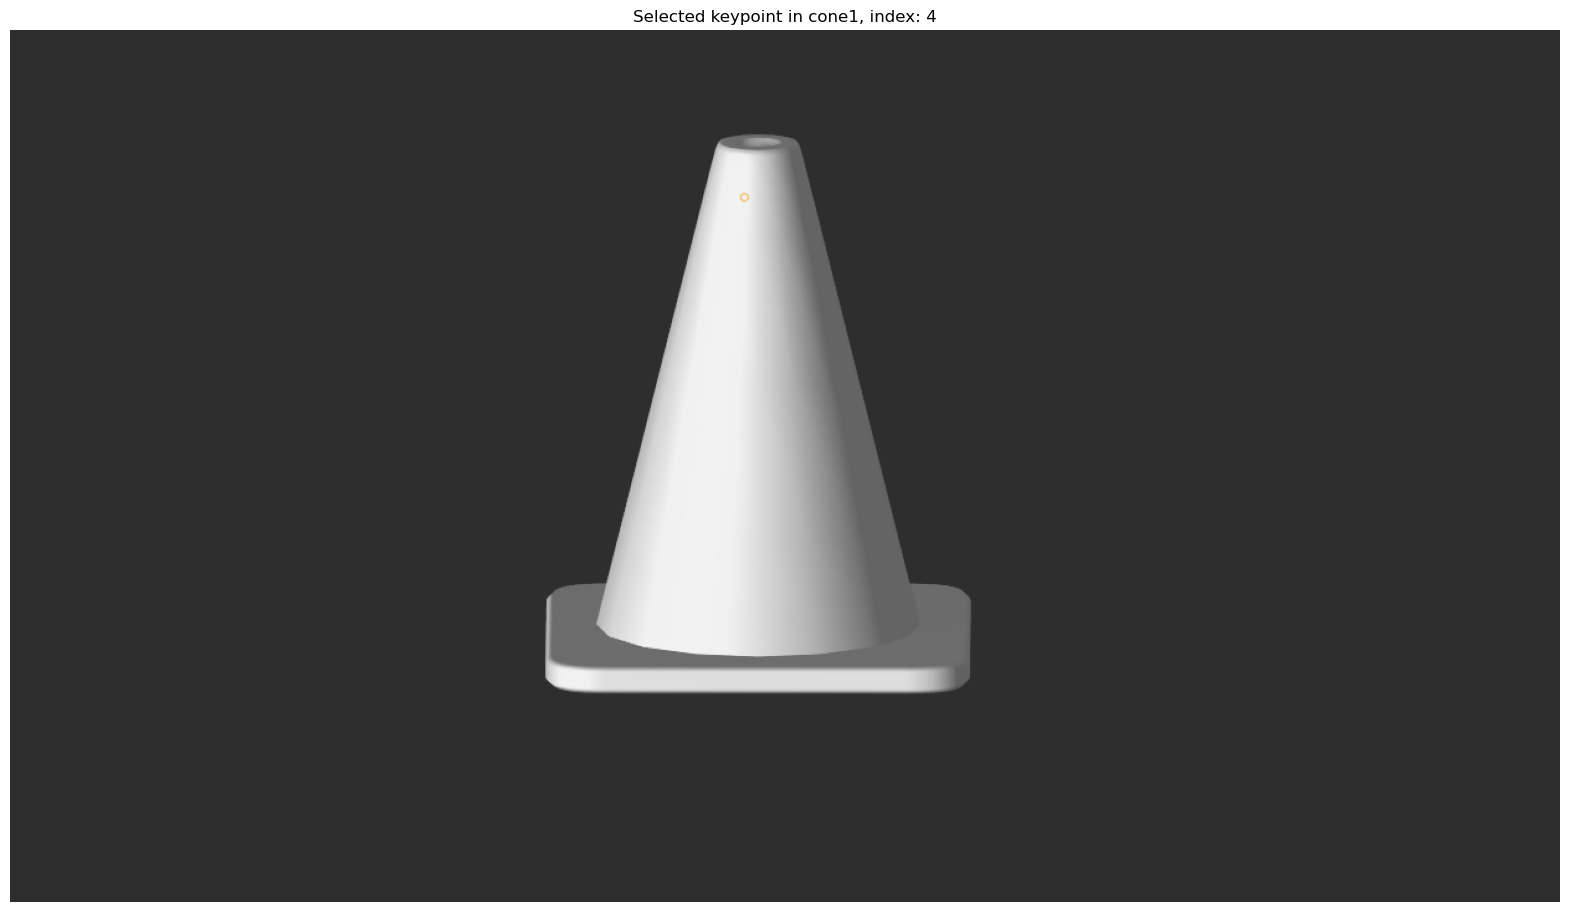

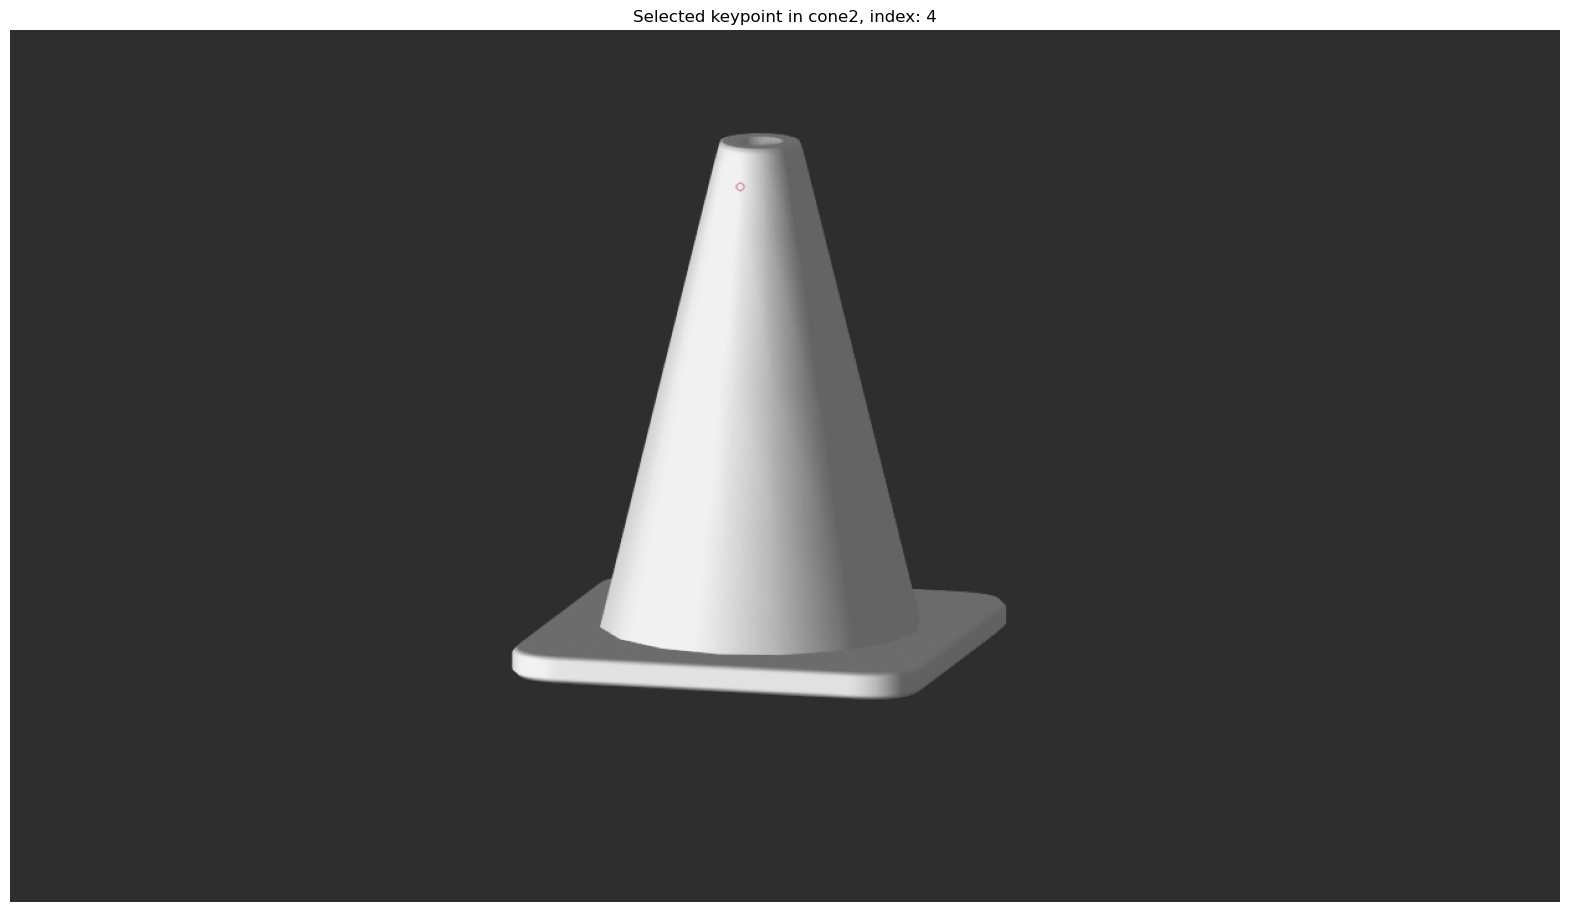

In [10]:
# %%script false
# draw single keypoint on image 0
kp_img1_draw_single = cv.drawKeypoints(im1, [kp1], None, flags=None)
plt.figure(figsize=(20, 20))
plt.imshow(kp_img1_draw_single)
plt.axis("off")
plt.title(f"Selected keypoint in {im_name1}, index: {kp_index}")
# save figure
plt.show()

# draw single keypoint on image 1
kp_img2_draw_single = cv.drawKeypoints(im2, [kp2], None, flags=None)
plt.figure(figsize=(20, 20))
plt.imshow(kp_img2_draw_single)
plt.axis("off")
plt.title(f"Selected keypoint in {im_name2}, index: {kp_index}")
# save figure
plt.show()

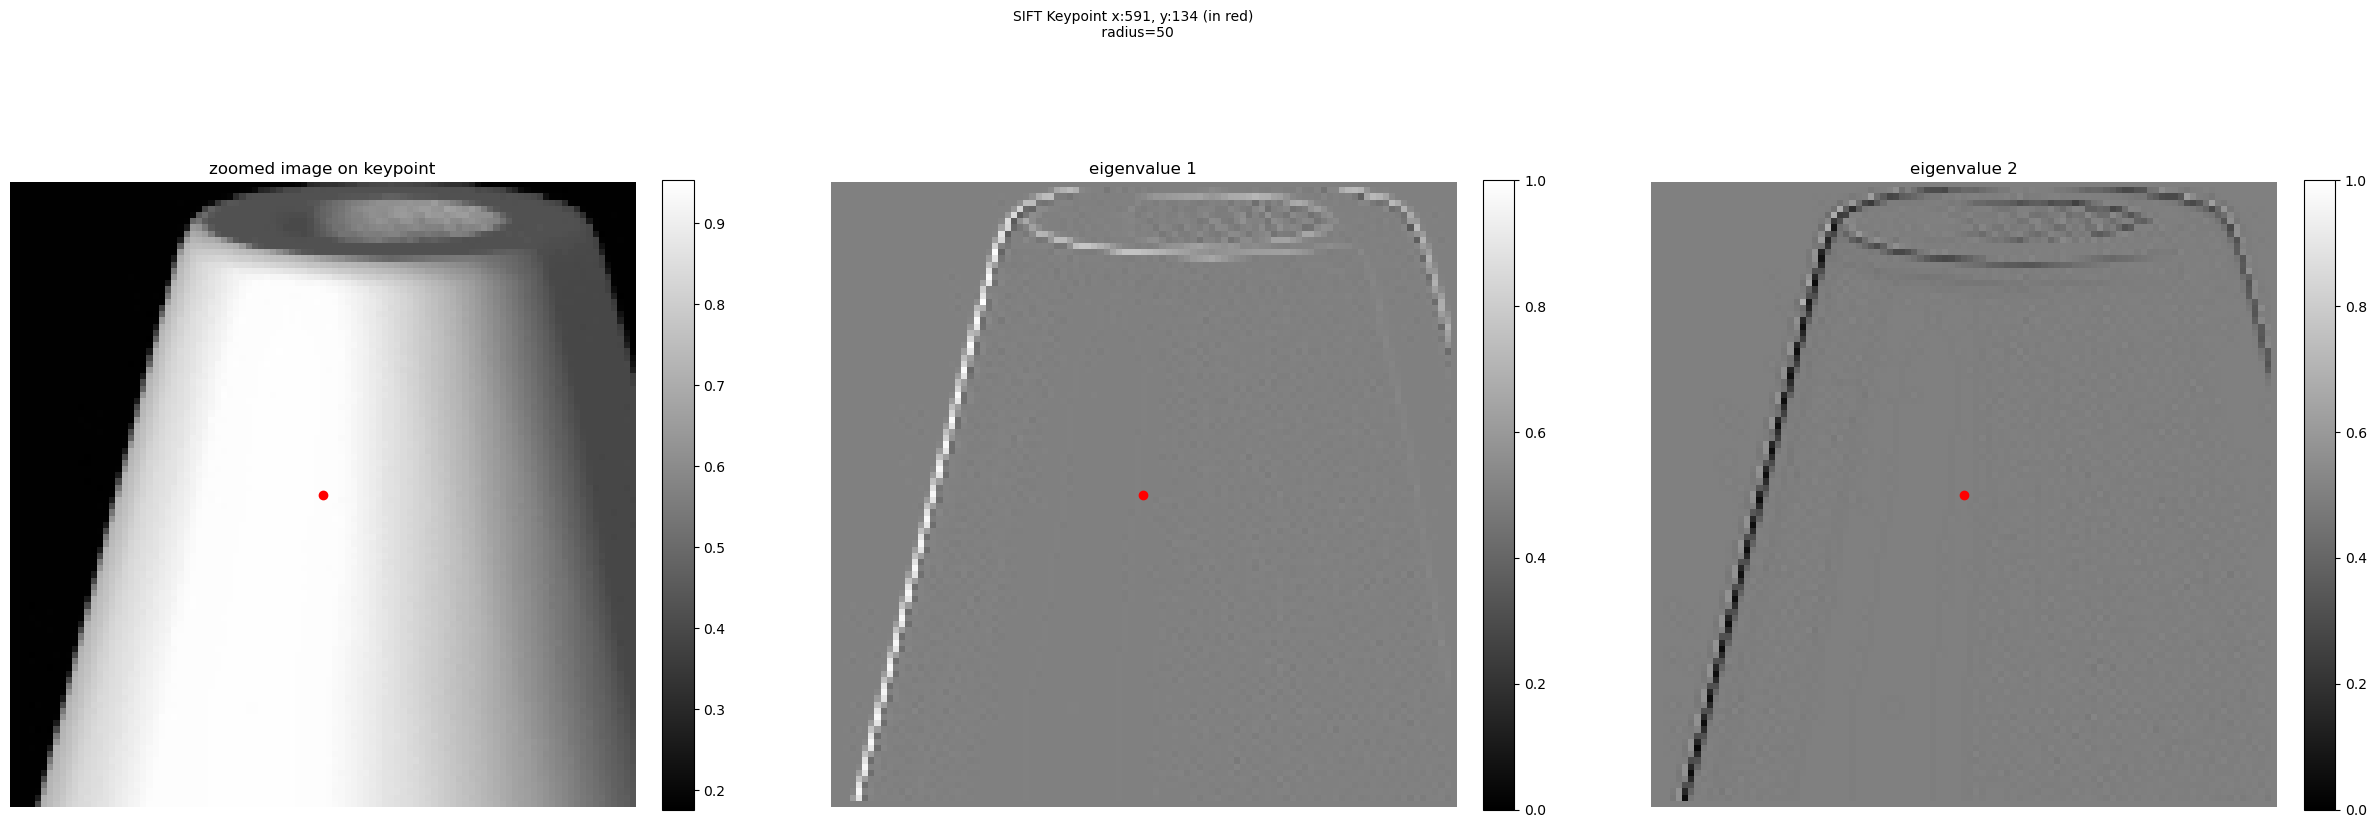

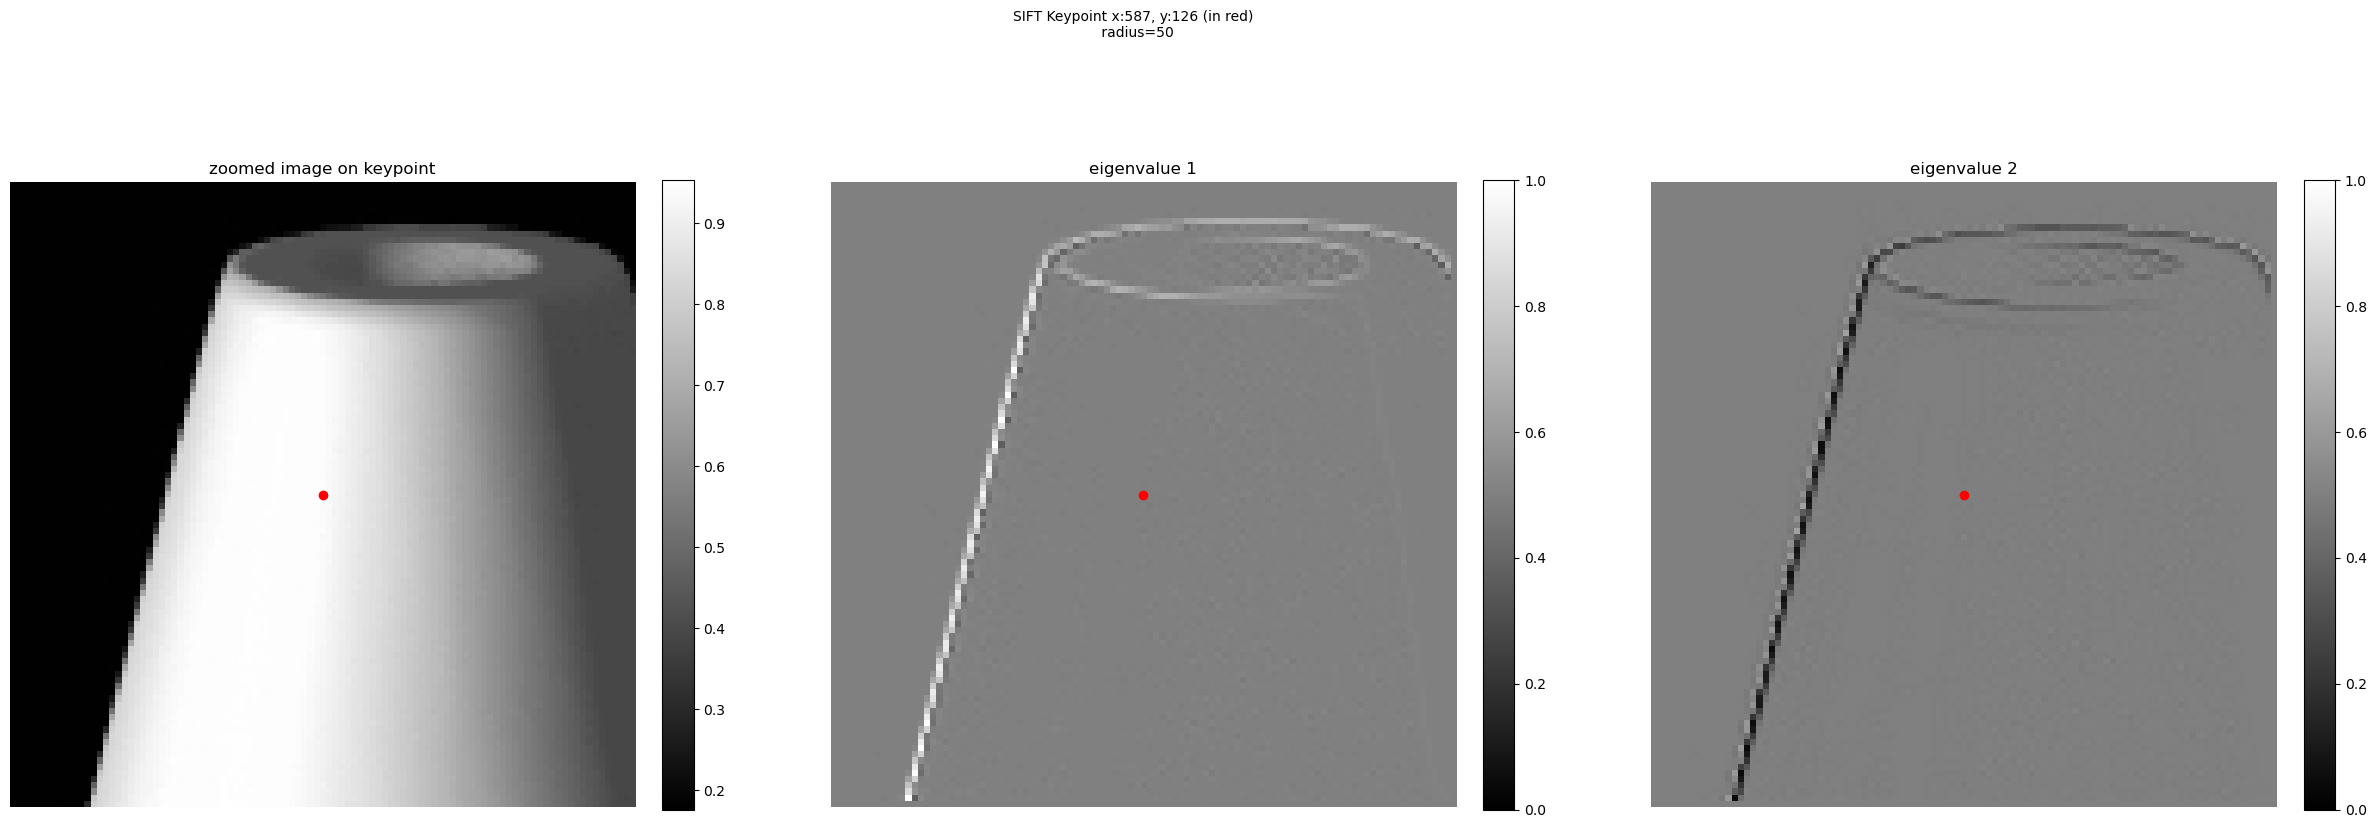

In [11]:
# %%script false
# display the figure of curvature values on the float versions
eigval_fig1 = vh.visualize_curvature_values(float_im1, kp1, zoom_radius)
plt.figure(eigval_fig1.number)
plt.show()

eigval_fig2 = vh.visualize_curvature_values(float_im2, kp2, zoom_radius)
plt.figure(eigval_fig2.number)
plt.show()

Display curvature directions side by side


In [12]:
# %%script false
dir_fig = vh.compare_directions(float_im1, float_im2, kp1, kp2, zoom_radius, dpi=800)

# show figure
plt.figure(dir_fig.number)
plt.show()

Show gradients side by side²


In [13]:
# %%script false
grad_fig = vh.compare_gradients(float_im1, float_im2, kp1, kp2, zoom_radius, dpi=800)

# show figure
plt.figure(grad_fig.number)
plt.show()

# Compute histograms descriptors of keypoints


In [14]:
kp_pos = []
for kp in (kp1, kp2):
    # convert into integer
    pos = np.round(kp.pt).astype(int)
    pos = tuple(pos)
    kp_pos.append(pos)


# define parameters for the descriptor
border_size = 1
feature_radius = zoom_radius + 20

# crop the subimages around keypoints
crop_ims = [
    vh.crop_image_around_keypoint(float_ims[i], kp_pos[i], feature_radius)
    for i in range(2)
]

# compute zoomed positions
zoomed_pos = [feature_radius, feature_radius]

First descriptor with signs


In [15]:
# %%script false
# compute overall features of a subimage of first image
zoomed_features = [
    desc.compute_features_overall_posneg(crop_ims[i], border_size) for i in range(2)
]

In [16]:
# %%script false
descriptor_histograms_kps = [
    desc.compute_descriptor_histograms_posneg(zoomed_features[i], zoomed_pos) for i in range(2)
]


descriptor_names = [f"Descriptor of {im_names[i]}" for i in range(2)]


values_names = ["positive eigenvalues", "negative eigenvalues", "gradient directions"]

for i in range(2):
    desc.display_descriptor(
        descriptor_histograms_kps[i],
        descriptor_name=descriptor_names[i],
        values_names=values_names,
    )

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Second descriptor with order of eigenvalues


In [18]:
# %%script false

# compute overall features of a subimages


zoomed_features2 = [
    desc.compute_features_overall_abs(crop_ims[i], border_size) for i in range(2)
]

In [19]:
# %%script false

descriptor_histograms_kps2 = [
    desc.compute_descriptor_histograms_1_2(zoomed_features2[i], zoomed_pos)
    for i in range(2)
]



descriptor_names2 = [f"Descriptor 2 of {im_names[i]}" for i in range(2)]



values_names2 = [
    "first principal direction",
    "second principal direction",
    "gradient directions",
]



for i in range(2):
    desc.display_descriptor(
        descriptor_histograms_kps2[i],
        descriptor_name=descriptor_names2[i],
        values_names=values_names2,
    )

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Problem: neighborhood is fixed here by the frame of the image, and not is not an intrinsec feature of the keypoint orientation


## Compare descriptors


In [ ]:
# %%script false

# flatten the descriptor histograms


flat_descriptor_histograms_kps = [
    desc.flatten_descriptor(descriptor_histograms_kps2[i]) for i in range(2)
]



# compute distance between descriptors


dist = desc.compute_descriptor_distance(
    flat_descriptor_histograms_kps[0], flat_descriptor_histograms_kps[1]
)

dist

Couldn't find program: 'false'


Look at a neighbor of one of the keypoints


In [ ]:
# %%script false
# index of chosen image


im_index = 1



neigh_pos = (kp_pos[im_index][0], kp_pos[im_index][1] + 10)


# crop the subimage around the neighbor


neigh_crop_im = vh.crop_image_around_keypoint(
    float_ims[im_index], neigh_pos, feature_radius
)



# compute overall features of a subimage of second image around the neighbor


neigh_zoomed_features2 = desc.compute_features_overall_abs(neigh_crop_im, border_size)



# compute descriptor histograms of the neighbor


neigh_descriptor_histograms_kps2 = desc.compute_descriptor_histograms_1_2(
    neigh_zoomed_features2, zoomed_pos
)



# flatten the descriptor histograms


neigh_flat_descriptor_histograms_kps = desc.flatten_descriptor(
    neigh_descriptor_histograms_kps2
)



# compute distance between descriptors


neigh_dist = desc.compute_descriptor_distance(
    flat_descriptor_histograms_kps[0], neigh_flat_descriptor_histograms_kps
)

neigh_dist

Couldn't find program: 'false'


In [ ]:
# %%script false
# show the neighbor


plt.imshow(
    float_ims[im_index], cmap="gray", vmin=min_vals[im_index], vmax=max_vals[im_index]
)
plt.axis("off")



plt.scatter(neigh_pos[0], neigh_pos[1], c="r", s=5)


plt.show()

Couldn't find program: 'false'


Look at multiple neighbors


In [ ]:
# %%script false
nb_neighbors = 10


delta_pixel = 10


# generate nb_neighbors random coordinates shifts in 2D


neighbors_shifts = np.random.randint(
    -delta_pixel, delta_pixel + 1, size=(nb_neighbors, 2)
)


# compute the neighbor positions


neighbors_positions = np.array(kp_pos[im_index]) + neighbors_shifts



# crop the subimages around neighbors


neighbors_crop_ims = [
    vh.crop_image_around_keypoint(
        float_ims[im_index], neighbors_positions[i], feature_radius
    )
    for i in range(nb_neighbors)
]



# compute overall features of a subimage of second image around the neighbors


neighbors_zoomed_features2 = [
    desc.compute_features_overall_abs(neighbors_crop_ims[i], border_size)
    for i in range(nb_neighbors)
]



# compute descriptor histograms of the neighbors


neighbors_descriptor_histograms_kps2 = [
    desc.compute_descriptor_histograms_1_2(neighbors_zoomed_features2[i], zoomed_pos)
    for i in range(nb_neighbors)
]



# flatten the descriptor histograms


neighbors_flat_descriptor_histograms_kps = [
    desc.flatten_descriptor(neighbors_descriptor_histograms_kps2[i])
    for i in range(nb_neighbors)
]



# compute distances between descriptors


neighbors_dists = [
    desc.compute_descriptor_distance(
        flat_descriptor_histograms_kps[0], neighbors_flat_descriptor_histograms_kps[i]
    )
    for i in range(nb_neighbors)
]



# print the distances


for i, dist in enumerate(neighbors_dists):
    print(f"Distance with neighbor {i+1}: {dist:.2f}")

Couldn't find program: 'false'


## New feature: descriptor rotation with keypoint gradient orientation


In [20]:
# compute overall features of a subimage of first image
zoomed_features3 = [
    desc.compute_features_overall_abs(crop_ims[i], border_size) for i in range(2)
]

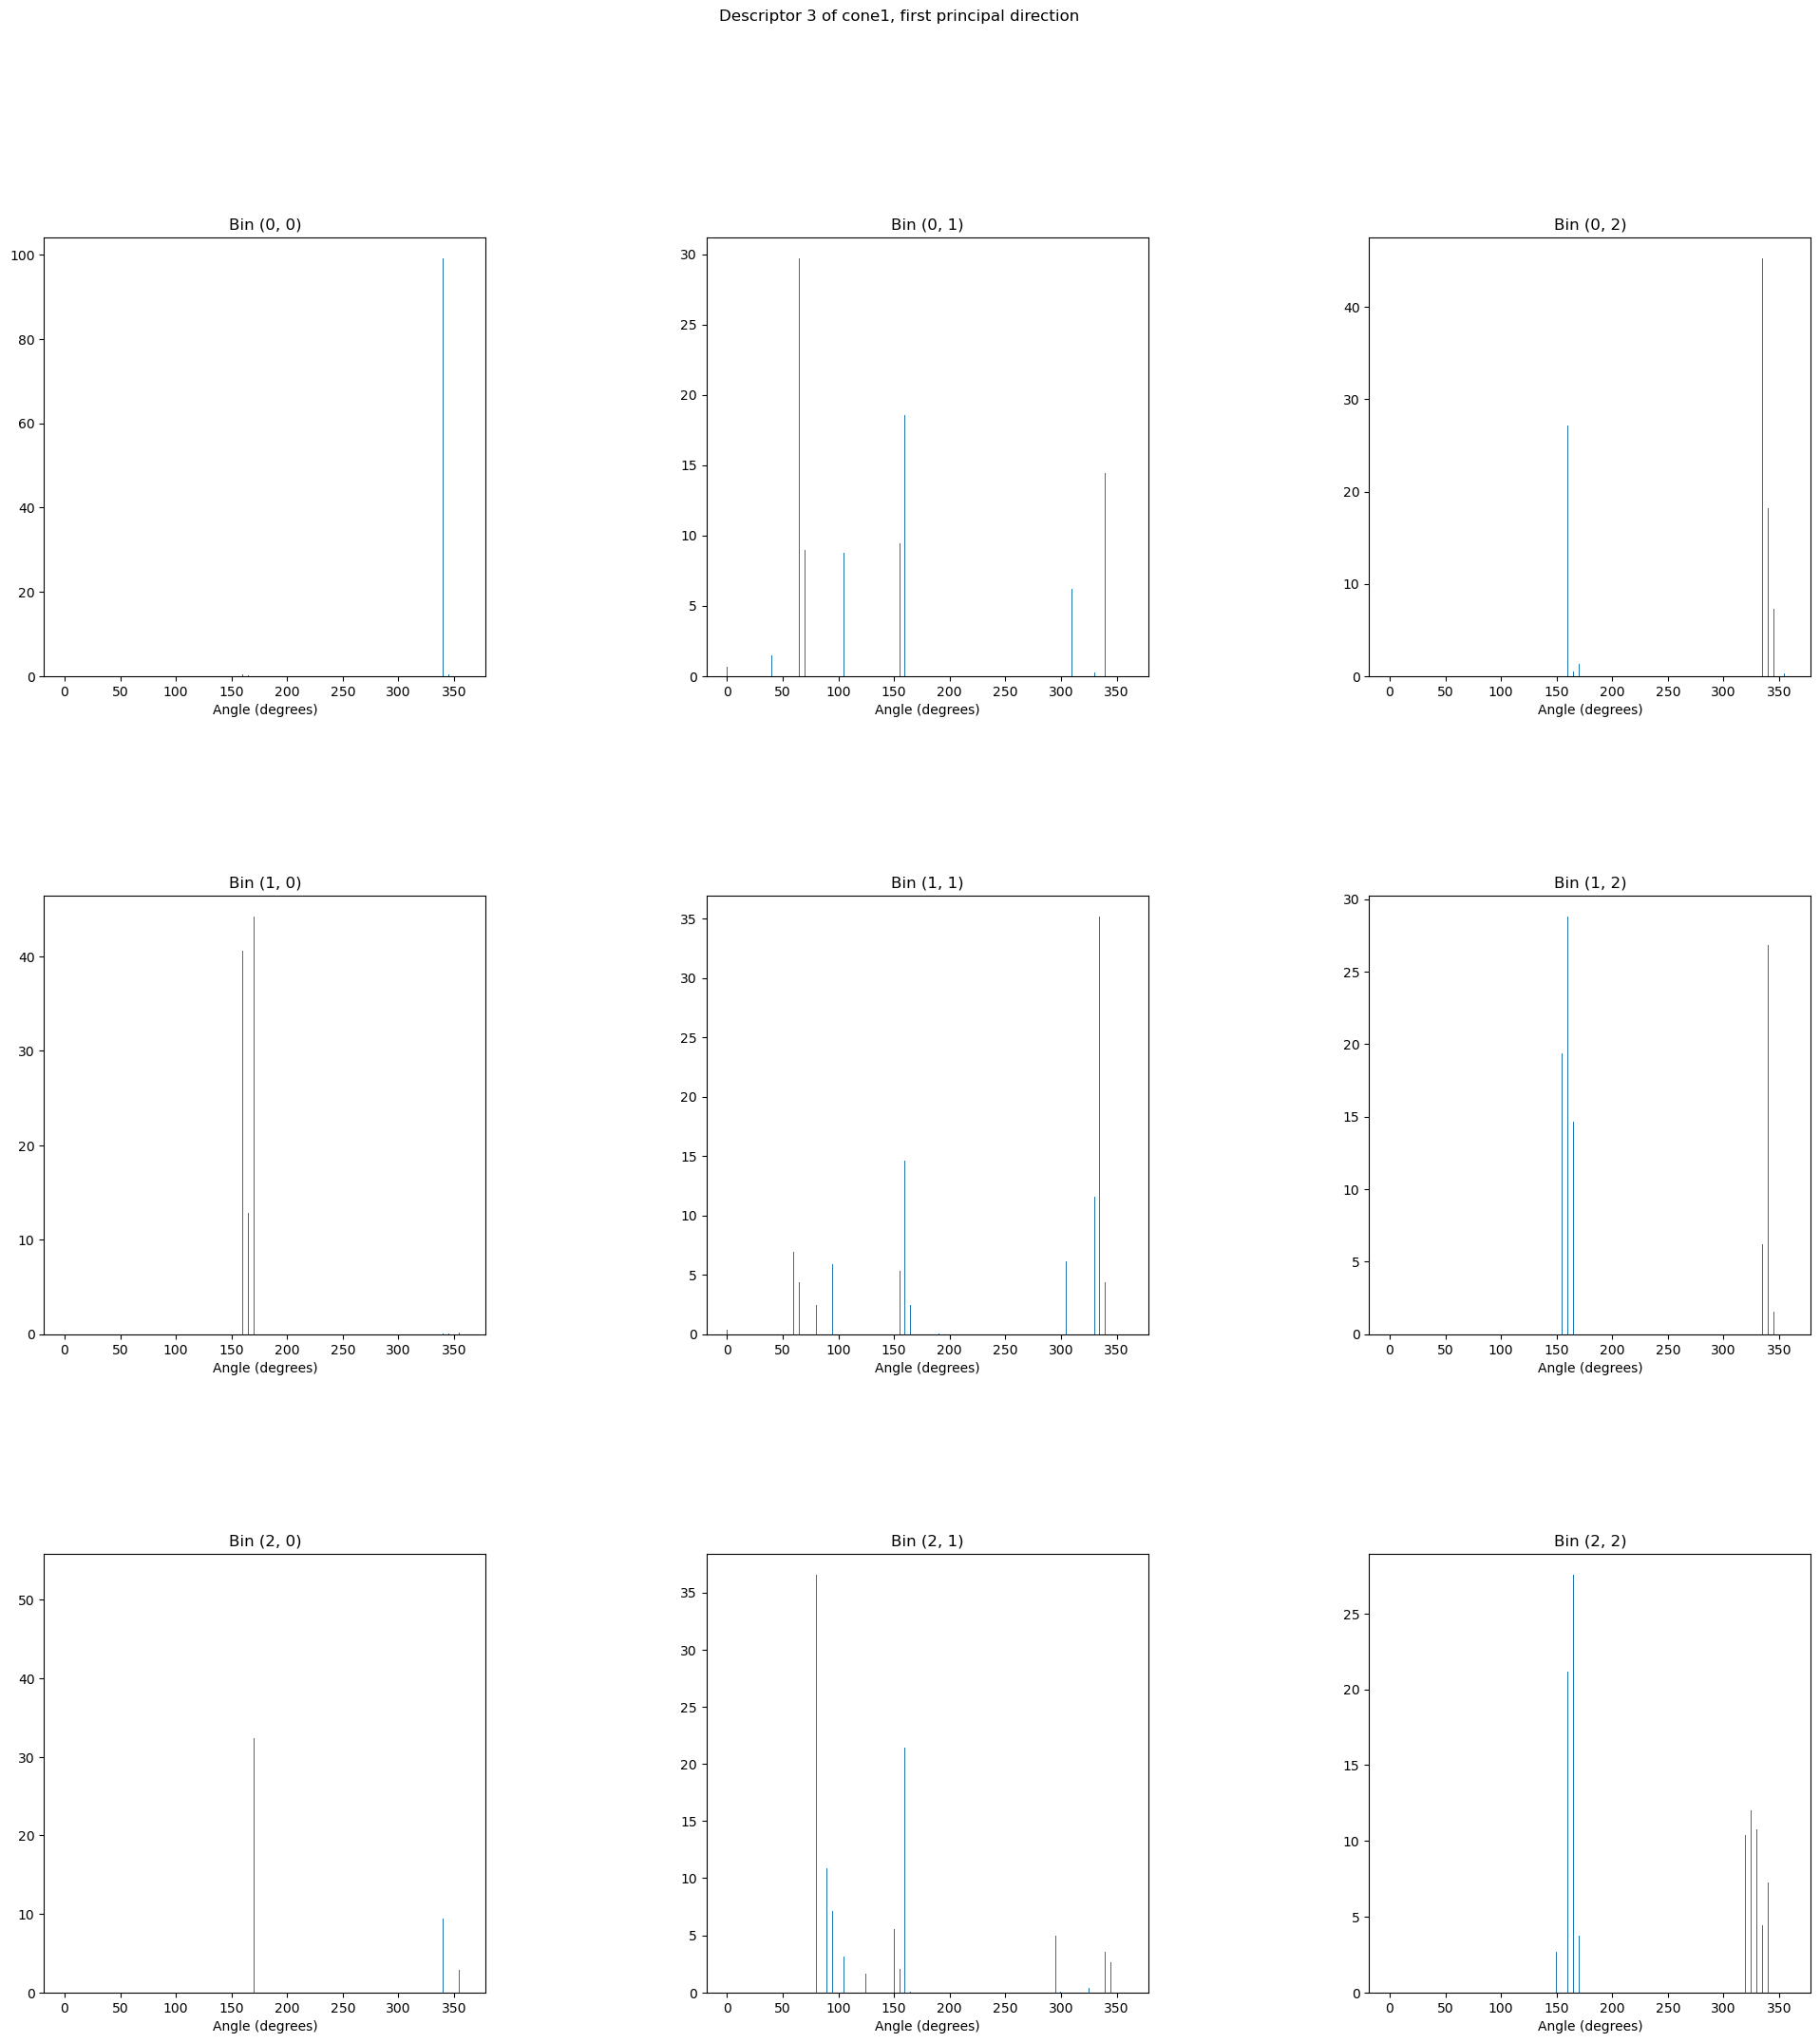

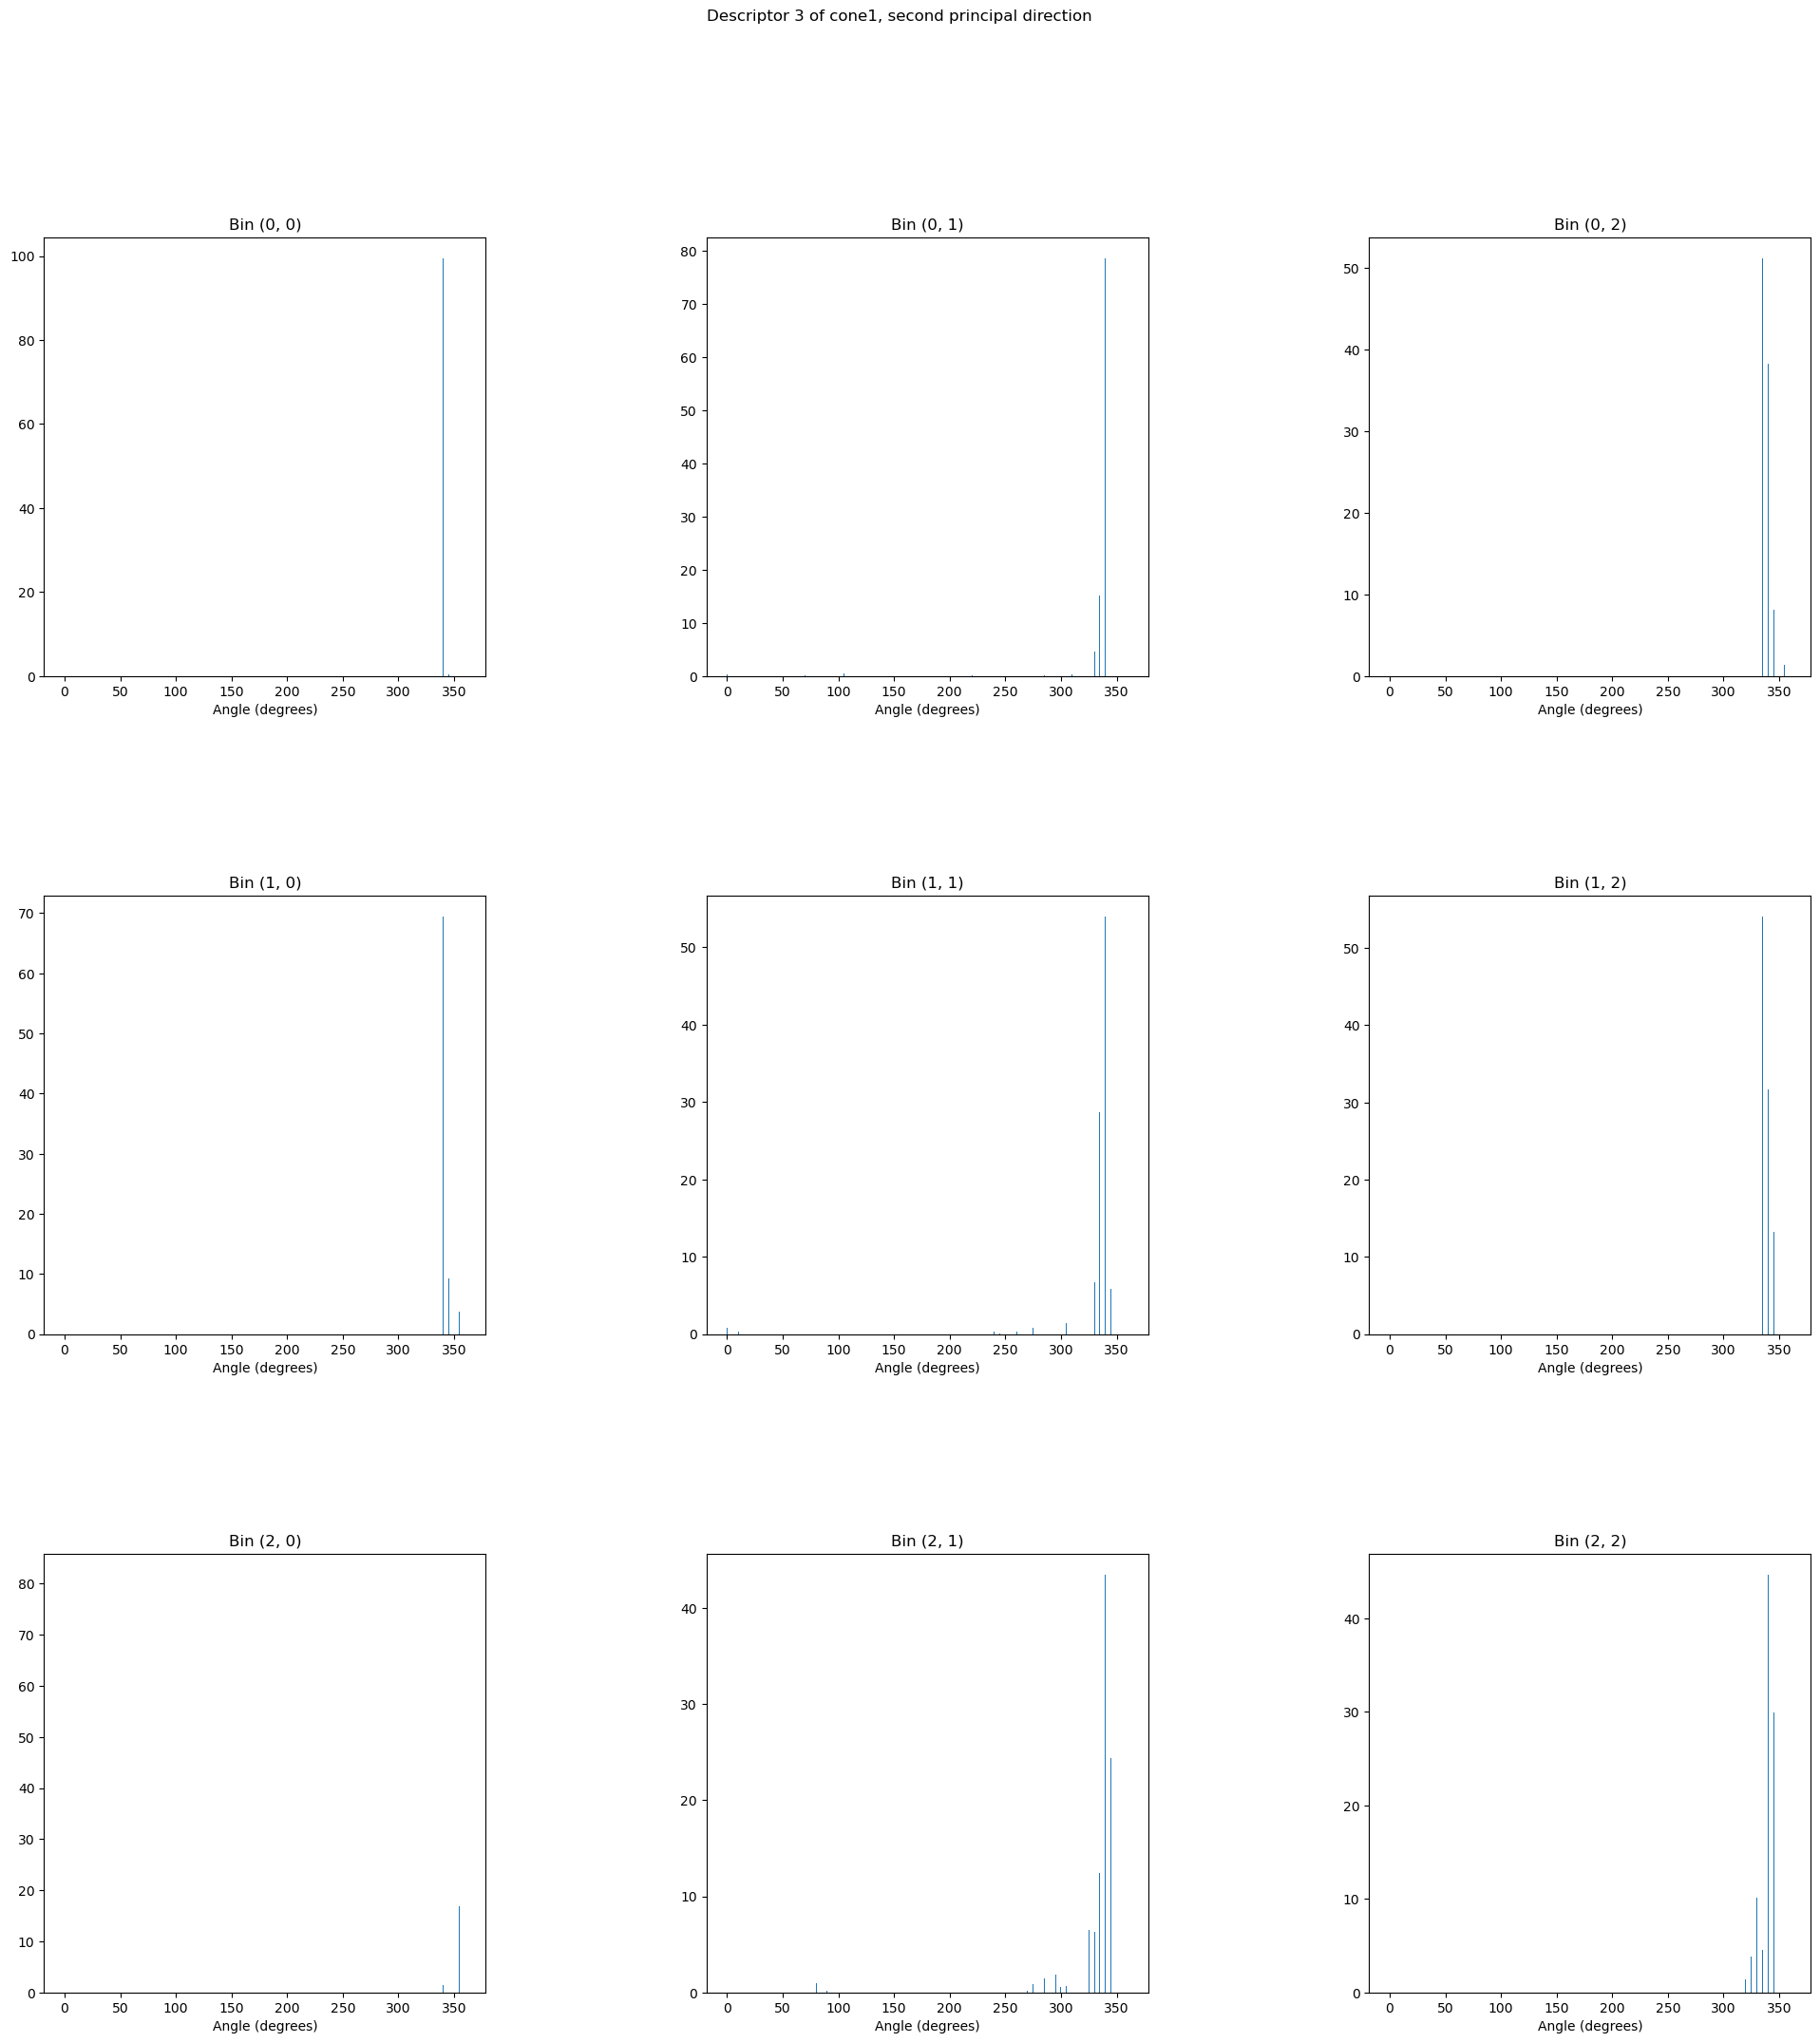

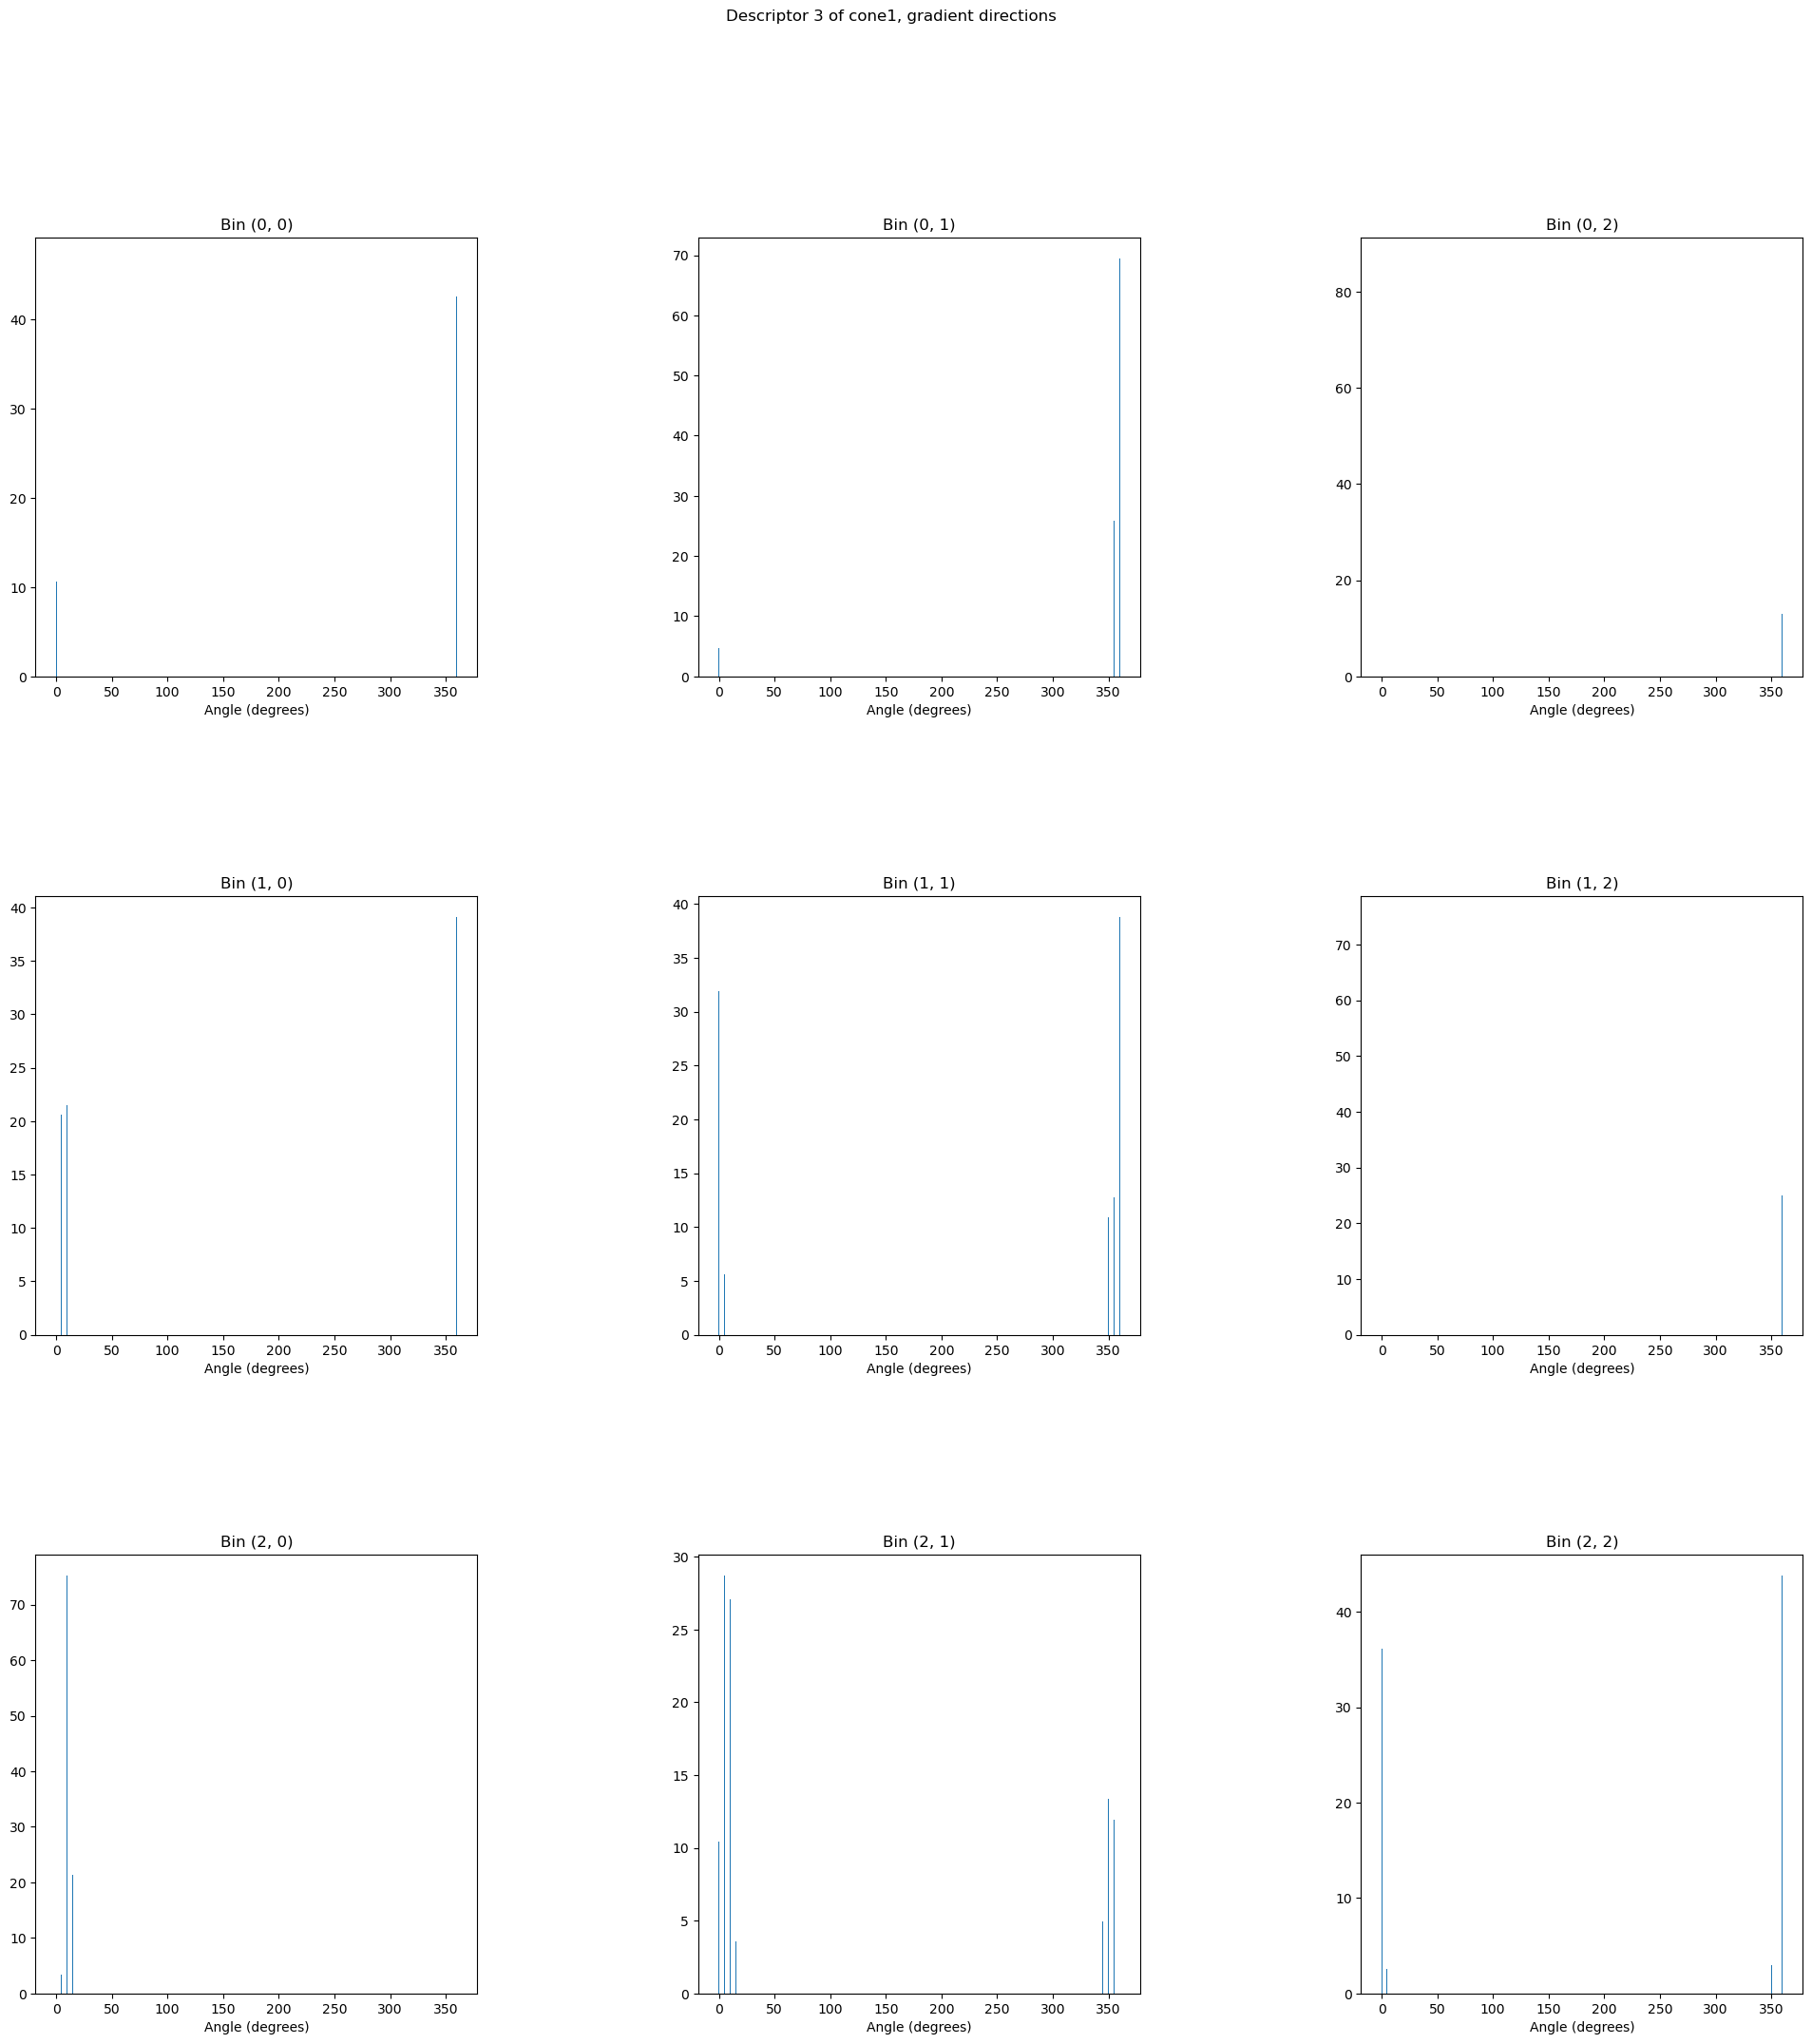

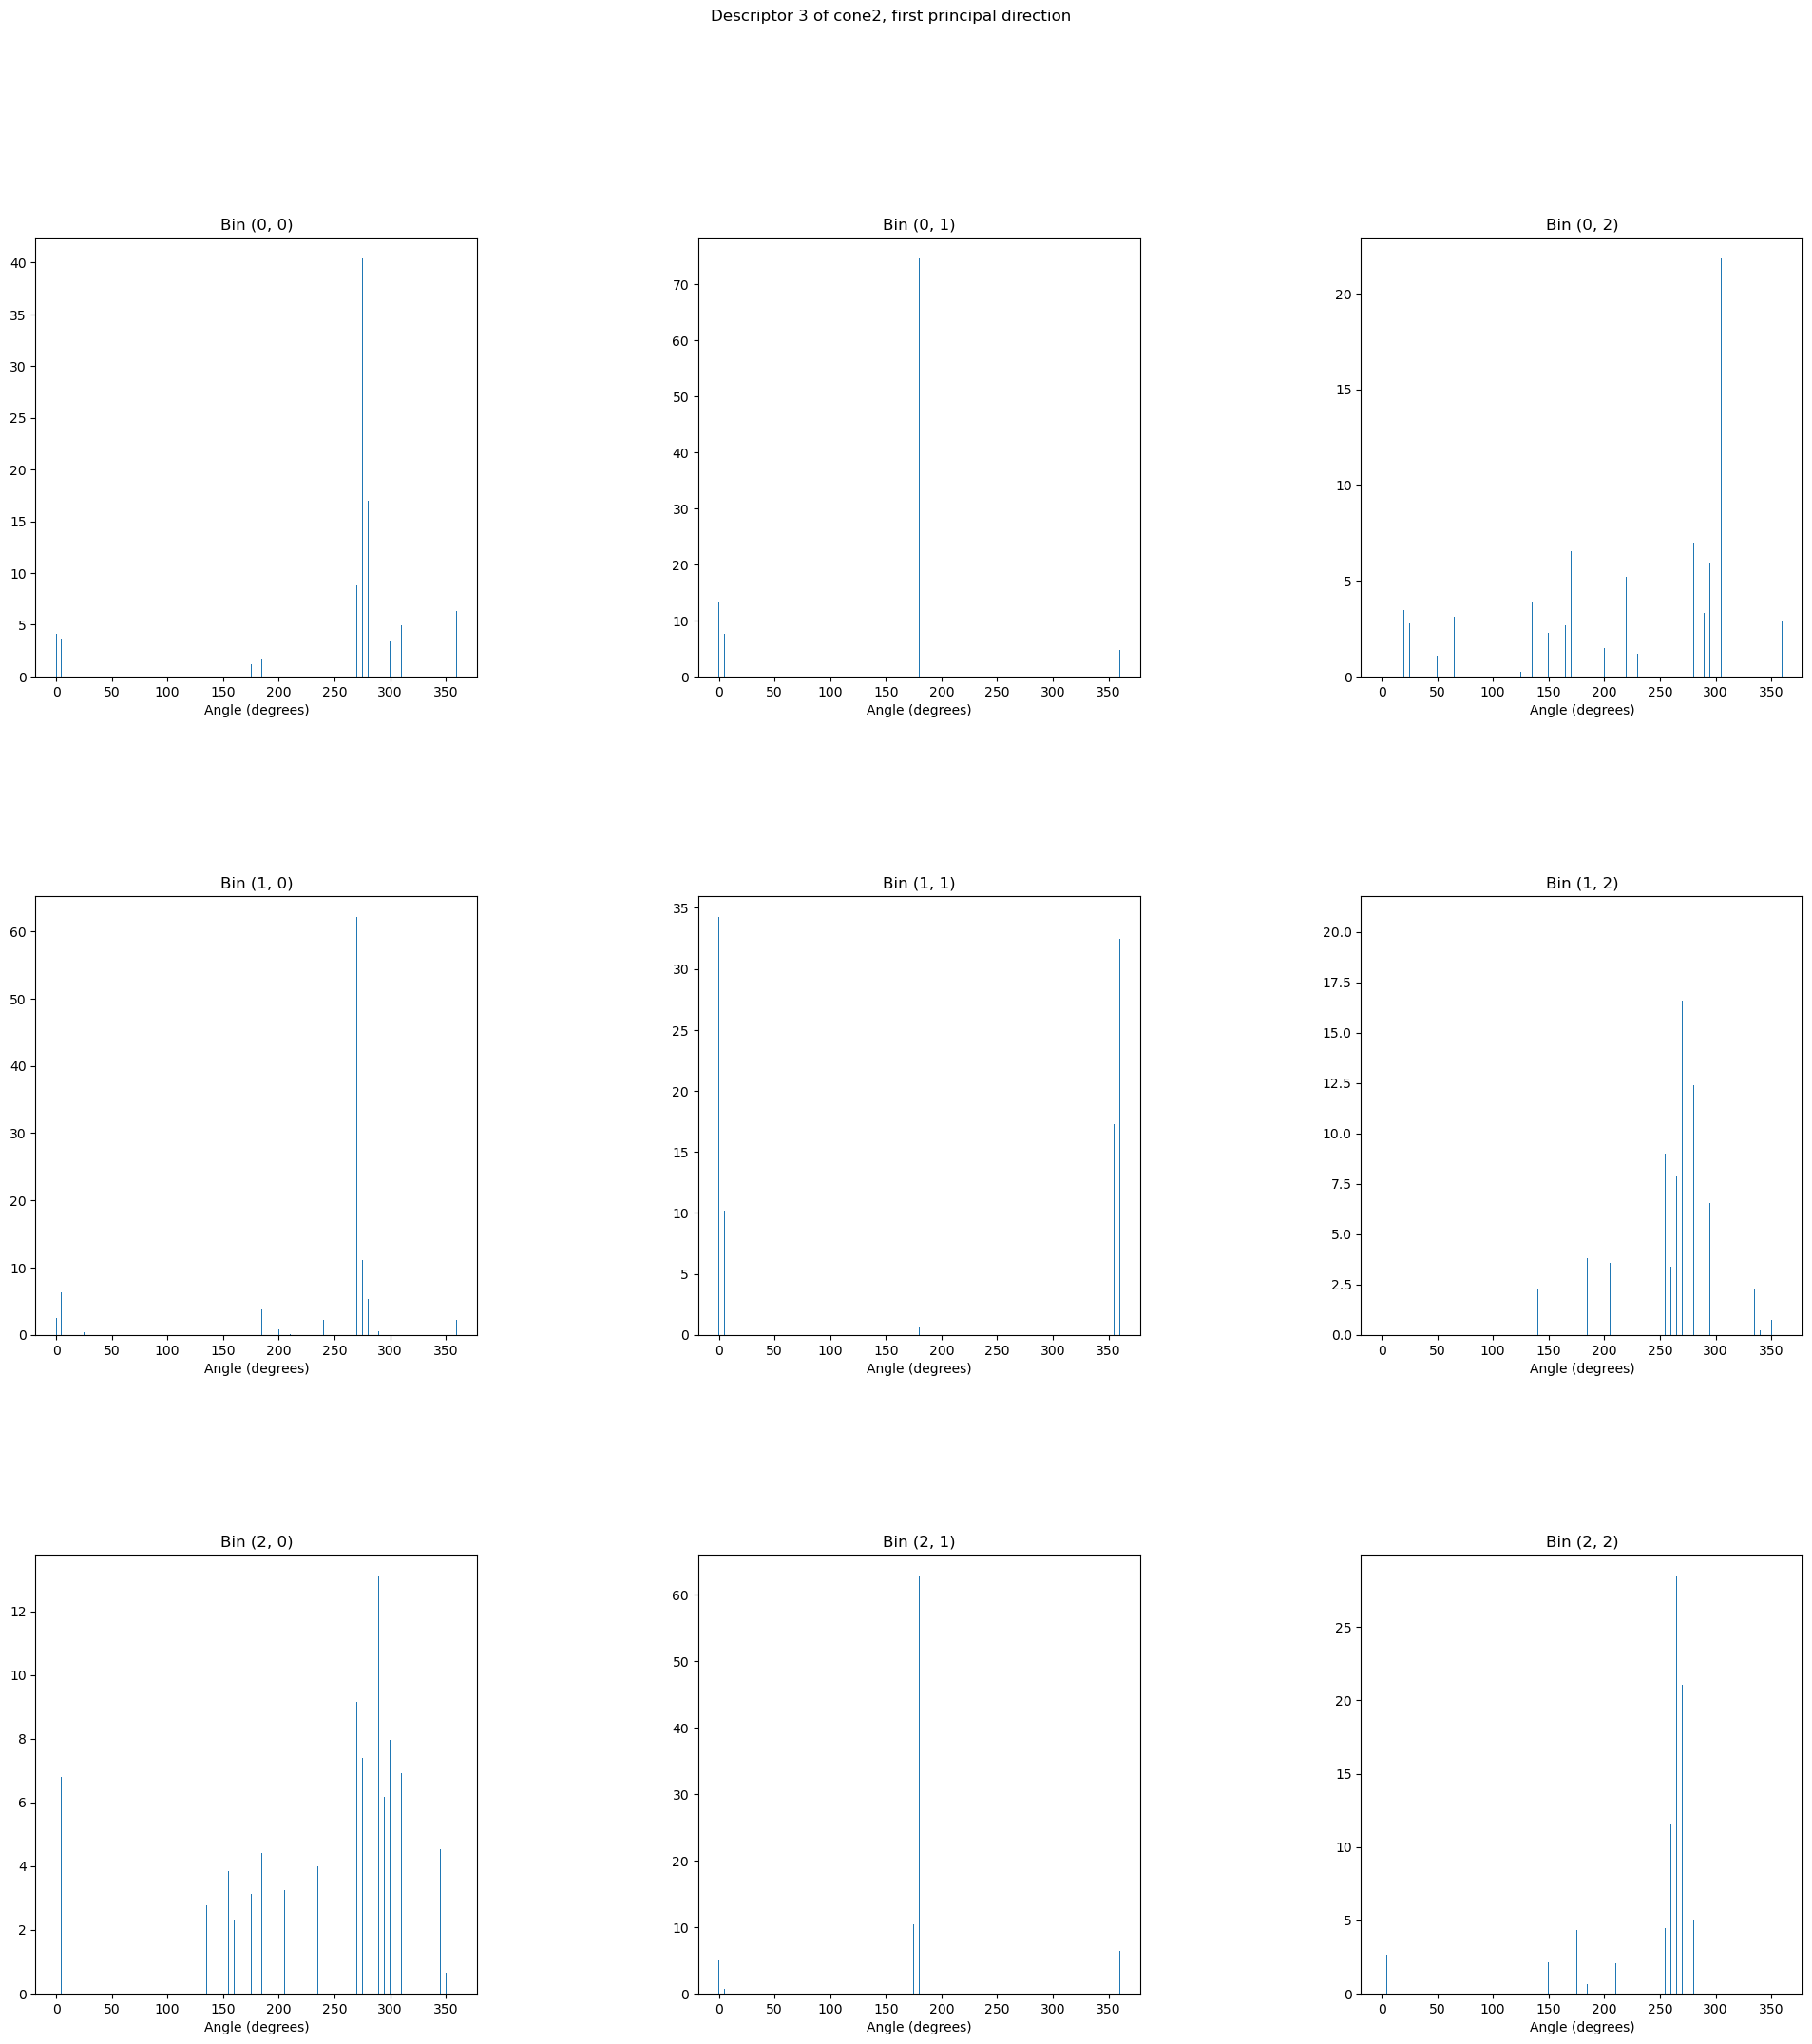

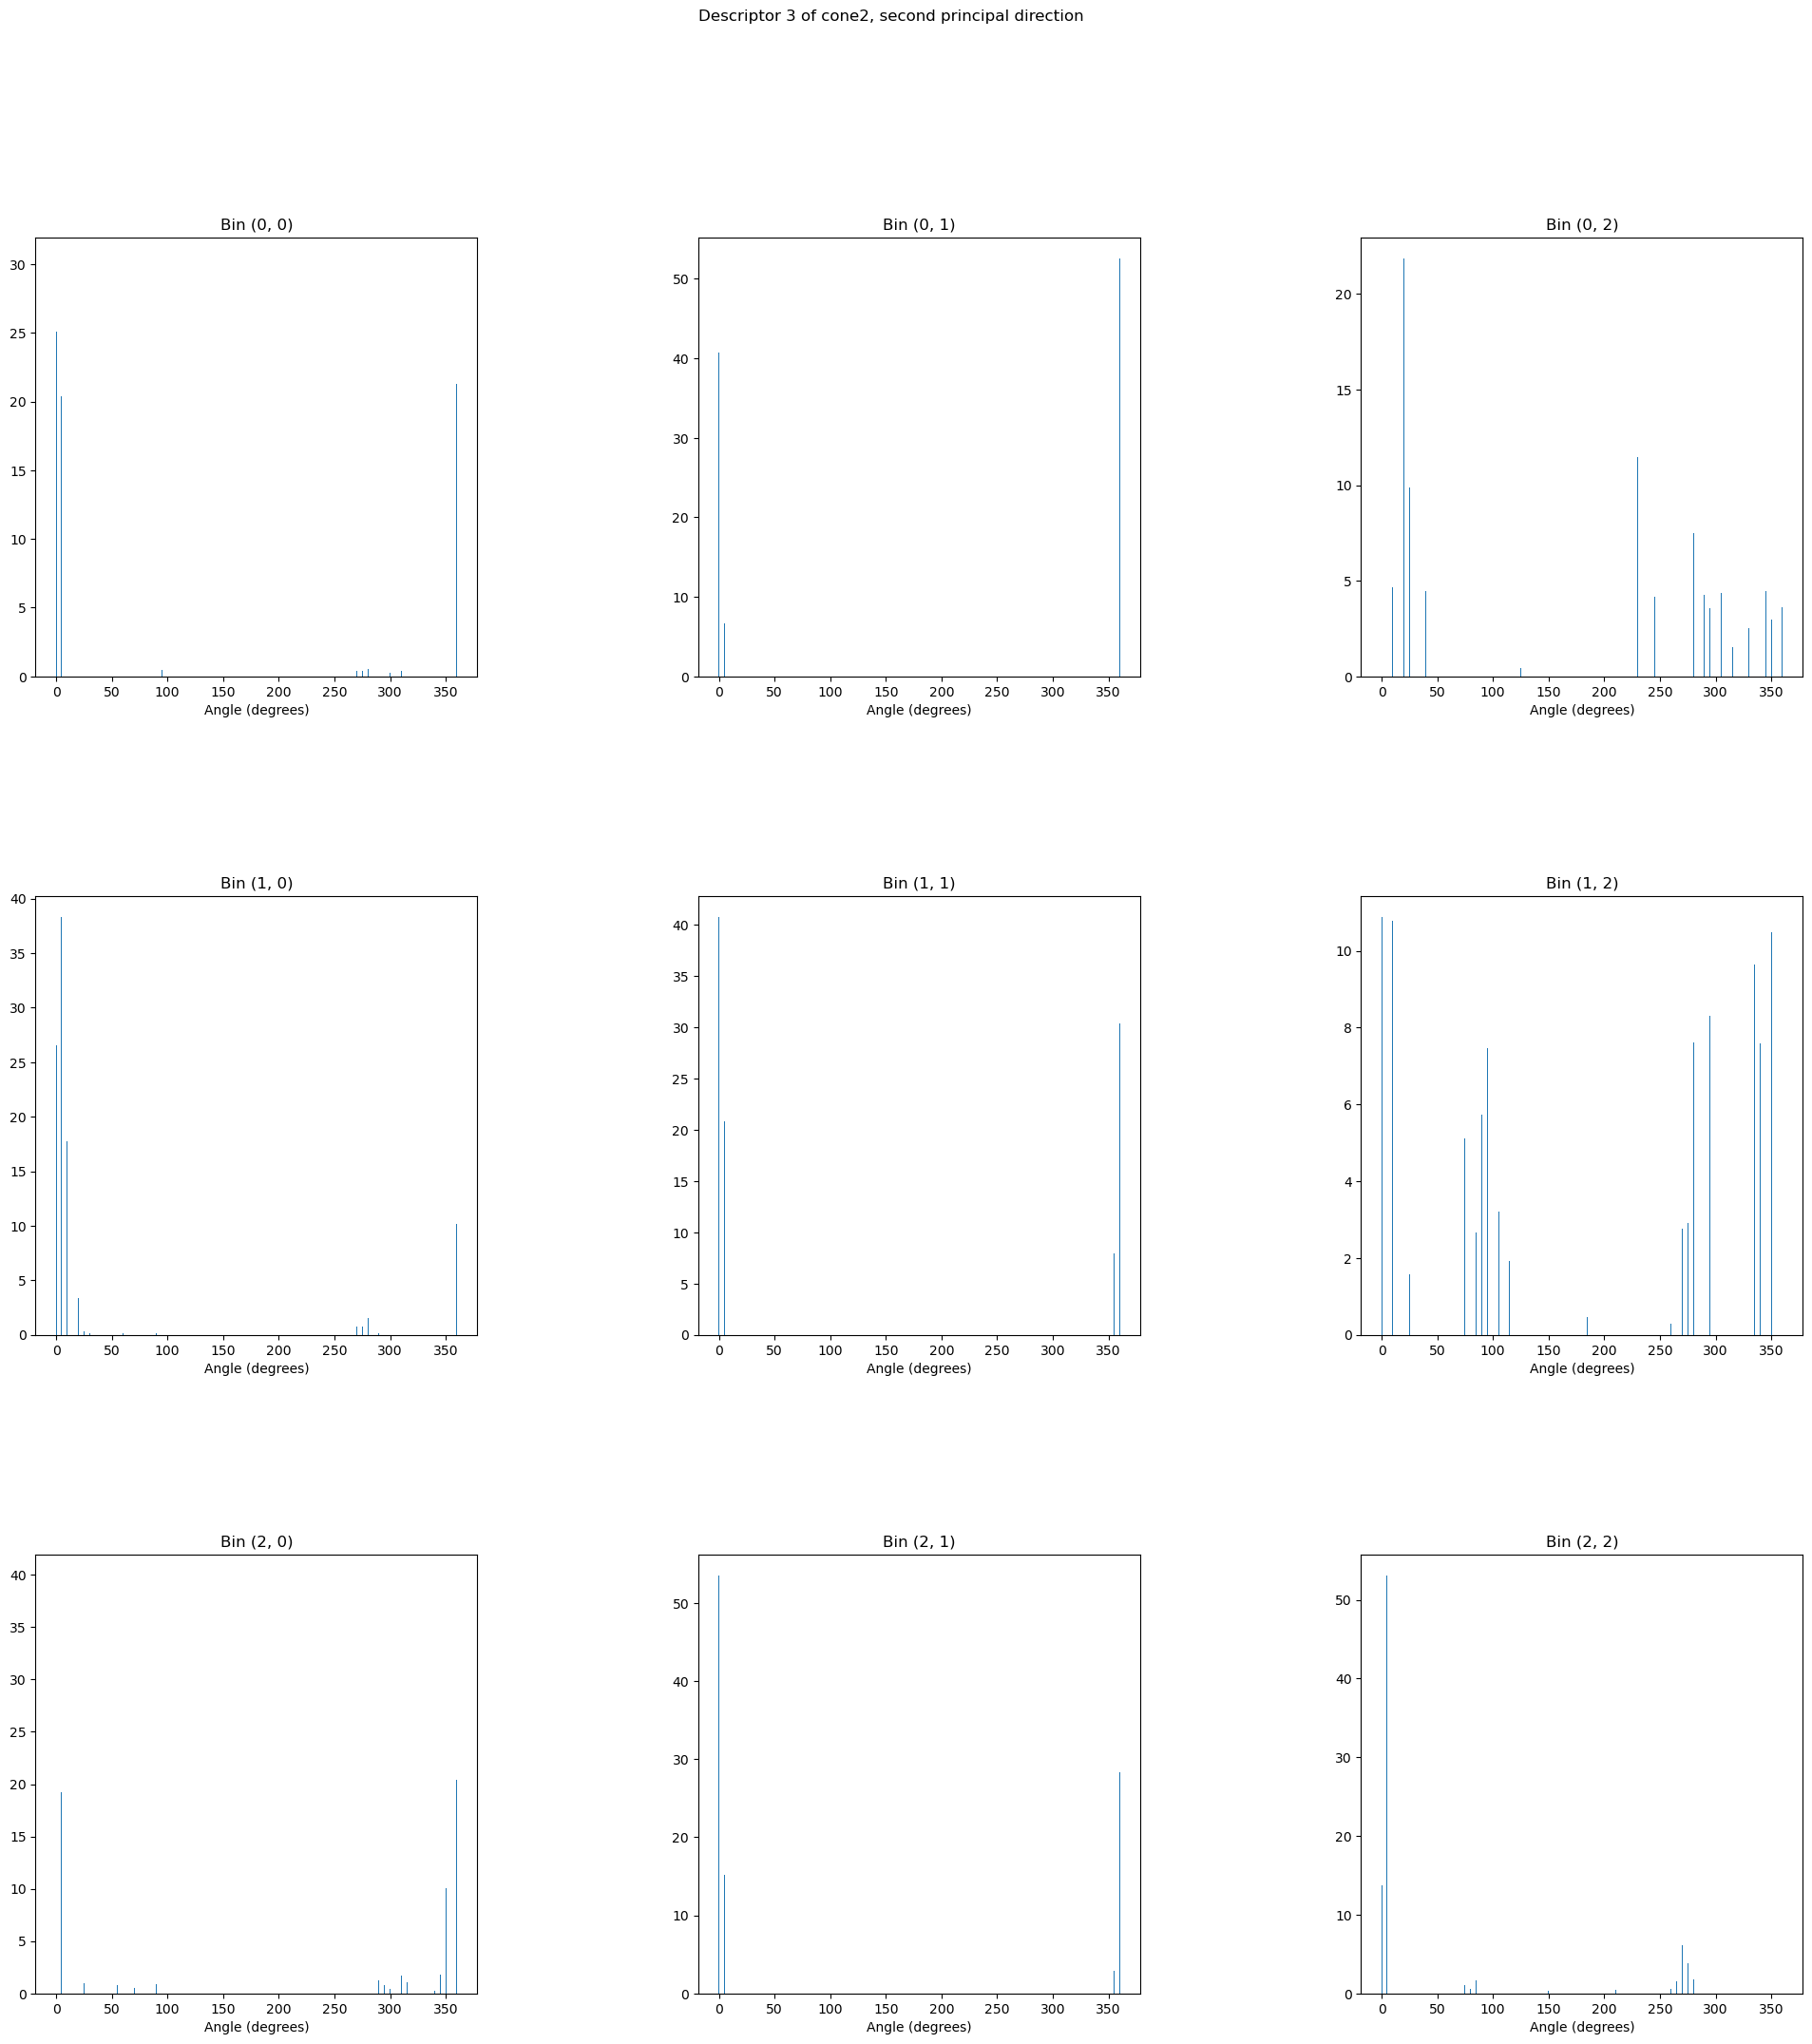

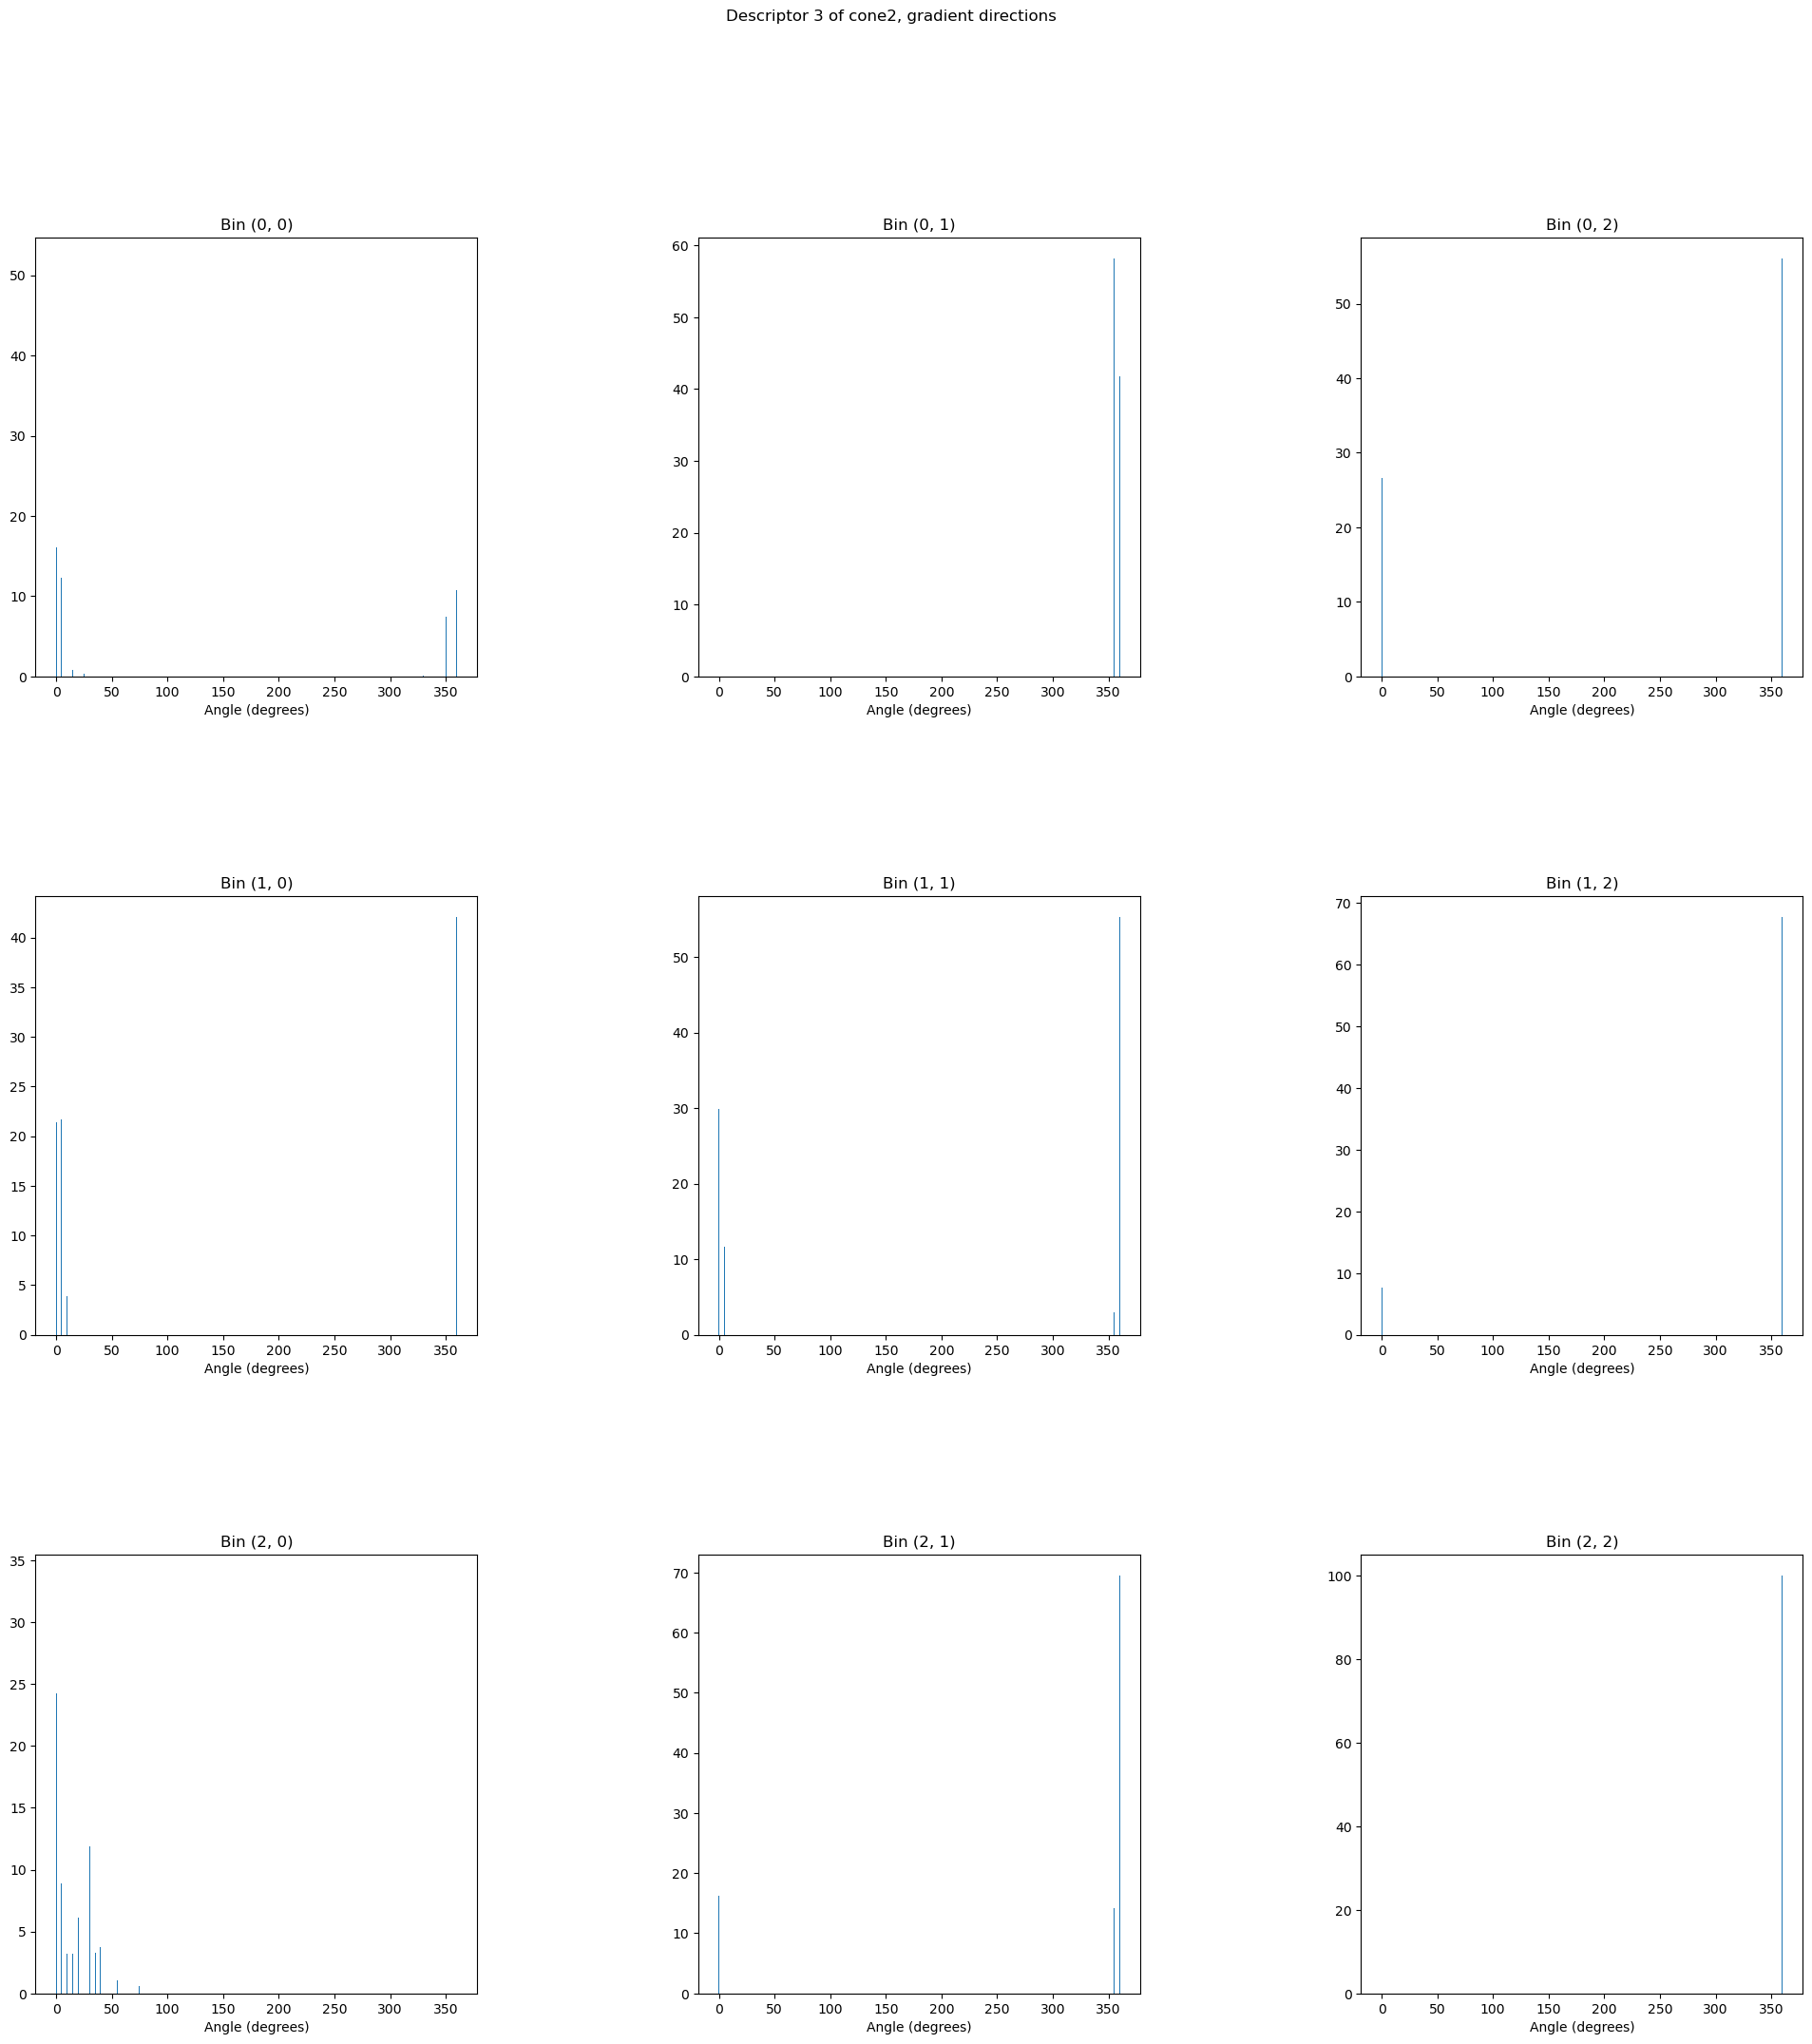

In [21]:
descriptor_histograms_kps3 = [
    desc.compute_descriptor_histograms_1_2_rotated(zoomed_features3[i], zoomed_pos)
    for i in range(2)
]


descriptor_names3 = [f"Descriptor 3 of {im_names[i]}" for i in range(2)]


values_names3 = [
    "first principal direction",
    "second principal direction",
    "gradient directions",
]

for i in range(2):
    desc.display_descriptor(
        descriptor_histograms_kps3[i],
        descriptor_name=descriptor_names3[i],
        values_names=values_names3,
    )

In [22]:
# %%script false

# flatten the descriptor histograms


flat_descriptor_histograms_kps3 = [
    desc.flatten_descriptor(descriptor_histograms_kps3[i]) for i in range(2)
]


# compute distance between descriptors


dist3 = desc.compute_descriptor_distance(
    flat_descriptor_histograms_kps3[0], flat_descriptor_histograms_kps3[1]
)

dist3

392.93542

Look at multiple neighbors


In [27]:
# %%script false
nb_neighbors = 10


delta_pixel = 10


# generate nb_neighbors random coordinates shifts in 2D


neighbors_shifts3 = np.random.randint(
    -delta_pixel, delta_pixel + 1, size=(nb_neighbors, 2)
)


# compute the neighbor positions


neighbors_positions3 = np.array(kp_pos[im_index]) + neighbors_shifts3


# crop the subimages around neighbors


neighbors_crop_ims3 = [
    vh.crop_image_around_keypoint(
        float_ims[im_index], neighbors_positions3[i], feature_radius
    )
    for i in range(nb_neighbors)
]


# compute overall features of a subimage of second image around the neighbors


neighbors_zoomed_features3 = [
    desc.compute_features_overall_abs(neighbors_crop_ims3[i], border_size)
    for i in range(nb_neighbors)
]


# compute descriptor histograms of the neighbors


neighbors_descriptor_histograms_kps3 = [
    desc.compute_descriptor_histograms_1_2_rotated(
        neighbors_zoomed_features3[i], zoomed_pos
    )
    for i in range(nb_neighbors)
]


# flatten the descriptor histograms


neighbors_flat_descriptor_histograms_kps3 = [
    desc.flatten_descriptor(neighbors_descriptor_histograms_kps3[i])
    for i in range(nb_neighbors)
]


# compute distances between descriptors


neighbors_dists3 = [
    desc.compute_descriptor_distance(
        flat_descriptor_histograms_kps3[0], neighbors_flat_descriptor_histograms_kps3[i]
    )
    for i in range(nb_neighbors)
]

Distance with neighbor 1: 409.24
Distance with neighbor 2: 384.17
Distance with neighbor 3: 398.25
Distance with neighbor 4: 443.15
Distance with neighbor 5: 368.08
Distance with neighbor 6: 435.67
Distance with neighbor 7: 418.58
Distance with neighbor 8: 414.76
Distance with neighbor 9: 401.34
Distance with neighbor 10: 392.89


In [28]:
# print the distances


for i, dist in enumerate(neighbors_dists3):
    print(f"Distance with neighbor {i+1}: {dist:.2f}")

Distance with neighbor 1: 409.24
Distance with neighbor 2: 384.17
Distance with neighbor 3: 398.25
Distance with neighbor 4: 443.15
Distance with neighbor 5: 368.08
Distance with neighbor 6: 435.67
Distance with neighbor 7: 418.58
Distance with neighbor 8: 414.76
Distance with neighbor 9: 401.34
Distance with neighbor 10: 392.89
